<a href="https://colab.research.google.com/github/Ry02024/SignateCup2024Summer_Ry032/blob/master/notebooks/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリのインストール

In [ ]:
# 必要なパッケージのインストール
!pip install japanize-matplotlib -q
!pip install catboost -q
!pip install category_encoders -q

# GitHubリポジトリのクローン
!git clone https://github.com/Ry02024/SignateCup2024Summer_Ry032.git

# 必要なライブラリのインポート
import japanize_matplotlib
import pandas as pd
import numpy as np
import re
import unicodedata
import datetime as dt
import matplotlib.pyplot as plt

# モデル関連ライブラリのインポート
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans

# カテゴリカルエンコーディングのためのライブラリ
from category_encoders import CatBoostEncoder

# クローンしたリポジトリ内のスクリプトをインポート
from SignateCup2024Summer_Ry032.src import preprocessing
from SignateCup2024Summer_Ry032.src import visualization
from SignateCup2024Summer_Ry032.src import model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 717.4 kB/s eta 0:00:00
Cloning into 'SignateCup2024Summer_Ry032'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 75 (delta 27), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 321.75 KiB | 2.40 MiB/s, done.
Resolving deltas: 100% (27/27), done.


## データの読み込み

In [ ]:
%cd SignateCup2024Summer_Ry032/

/content/SignateCup2024Summer_Ry032


In [ ]:
data_dir = "data/raw/"
train = pd.read_csv(data_dir + "train.csv")
test = pd.read_csv(data_dir + "test.csv")

In [ ]:
train_x = train.drop(['id', 'ProdTaken'], axis=1)
train_y = train['ProdTaken']
test_x = test.drop(['id'], axis=1)

# データ分析のPDCA：施策の生成

以下に、各データの前処理後の変数がどの尺度に属するかを説明し、その尺度に基づいた適切な可視化方法を提案します。

1. **Age（年齢）**
   - **尺度**: 比率尺度 (Ratio Scale)
   - **説明**: 年齢はゼロが意味を持つ連続した数値データであり、間隔も等しいため比率尺度です。
   - **適切な可視化方法**:
     - **ヒストグラム**: 年齢の分布を見るために有効です。
     - **箱ひげ図**: 年齢の中央値や四分位範囲、外れ値を確認するために使用できます。

2. **TypeofContact（連絡方法）**
   - **尺度**: 名義尺度 (Nominal Scale)
   - **説明**: 連絡方法はカテゴリデータであり、順序がないため名義尺度です。
   - **適切な可視化方法**:
     - **棒グラフ**: 各カテゴリの頻度を視覚化するために適しています。
     - **円グラフ**: 各カテゴリが全体のどれだけの割合を占めるかを示すのに適しています。

3. **CityTier（都市層）**
   - **尺度**: 順序尺度 (Ordinal Scale)
   - **説明**: 都市層は自然な順序を持つカテゴリデータであり、間隔が等しいとは限りませんが、順序があるため順序尺度に分類されます。
   - **適切な可視化方法**:
     - **棒グラフ**: 各都市層の頻度を視覚化するために適しています。
     - **円グラフ**: 各都市層が全体の中で占める割合を視覚化するために適しています。

4. **DurationOfPitch（プレゼン時間）**
   - **尺度**: 比率尺度 (Ratio Scale)
   - **説明**: プレゼン時間はゼロが意味を持つ連続した数値データであり、間隔も等しいため比率尺度です。
   - **適切な可視化方法**:
     - **ヒストグラム**: プレゼン時間の分布を見るために有効です。
     - **箱ひげ図**: プレゼン時間の中央値や四分位範囲、外れ値を確認するために使用できます。

5. **Occupation（ご職業）**
   - **尺度**: 順序尺度 (Ordinal Scale)
   - **説明**: 職業は自然な順序を持つカテゴリデータであり、間隔が等しいとは限りませんが、順序があるため順序尺度に分類されます。
   - **適切な可視化方法**:
     - **棒グラフ**: 各職業カテゴリの頻度を視覚化するために適しています。
     - **円グラフ**: 各職業カテゴリが全体の中で占める割合を視覚化するために適しています。

6. **Gender（性別）**
   - **尺度**: 名義尺度 (Nominal Scale)
   - **説明**: 性別は順序がないカテゴリデータであるため名義尺度です。
   - **適切な可視化方法**:
     - **棒グラフ**: 性別ごとの頻度を視覚化するために適しています。
     - **円グラフ**: 各性別が全体のどれだけの割合を占めるかを示すのに適しています。

7. **NumberOfPersonVisiting（同行者の数）**
   - **尺度**: 比率尺度 (Ratio Scale)
   - **説明**: 同行者の数はゼロが意味を持つ離散的な数値データであり、間隔も等しいため比率尺度です。
   - **適切な可視化方法**:
     - **棒グラフ**: 各同行者数の頻度を視覚化するために適しています。特に、少数の離散値の場合に適しています。
     - **円グラフ**: 各同行者数が全体のどれだけの割合を占めるかを示すのに適しています。

8. **NumberOfFollowups（フォローアップ回数）**
   - **尺度**: 比率尺度 (Ratio Scale)
   - **説明**: フォローアップ回数はゼロが意味を持つ連続した数値データであり、間隔も等しいため比率尺度です。
   - **適切な可視化方法**:
     - **ヒストグラム**: フォローアップ回数の分布を見るために有効です。
     - **箱ひげ図**: フォローアップ回数の中央値や四分位範囲、外れ値を確認するために使用できます。

9. **ProductPitched（売り込み商品の種類）**
   - **尺度**: 名義尺度 (Nominal Scale)
   - **説明**: 売り込み商品の種類は順序がないカテゴリデータであるため名義尺度です。
   - **適切な可視化方法**:
     - **棒グラフ**: 各商品の種類の頻度を視覚化するために適しています。
     - **円グラフ**: 各商品の種類が全体のどれだけの割合を占めるかを示すのに適しています。

10. **PreferredPropertyStar（ホテル施設の優先評価）**
    - **尺度**: 順序尺度 (Ordinal Scale)
    - **説明**: ホテル施設の優先評価は自然な順序を持つデータであり、間隔が等しいとは限りませんが、順序があるため順序尺度に分類されます。
    - **適切な可視化方法**:
      - **棒グラフ**: 各評価の頻度を視覚化するために適しています。
      - **円グラフ**: 各評価が全体のどれだけの割合を占めるかを示すのに適しています。

11. **NumberOfTrips（年間旅行数）**
    - **尺度**: 比率尺度 (Ratio Scale)
    - **説明**: 旅行回数はゼロが意味を持つ連続した数値データであり、間隔も等しいため比率尺度です。
    - **適切な可視化方法**:
      - **ヒストグラム**: 旅行回数の分布を見るために有効です。
      - **棒グラフ**: 旅行回数ごとの頻度を視覚化するために適しています。

12. **Passport（パスポートの所持）**
    - **尺度**: 名義尺度 (Nominal Scale)
    - **説明**: パスポートの所持は順序がないカテゴリデータであるため名義尺度です。
    - **適切な可視化方法**:
      - **棒グラフ**: パスポート所持者と非所持者の頻度を視覚化するために適しています。
      - **円グラフ**: パスポートの所持状態が全体のどれだけの割合を占めるかを示すのに適しています。

13. **PitchSatisfactionScore（満足度スコア）**
    - **尺度**: 順序尺度 (Ordinal Scale)
    - **説明**: 満足度スコアは自然な順序を持つデータであり、間隔が等しいとは限りませんが、順序があるため順序尺度に分類されます。
    - **適切な可視化方法**:
      - **棒グラフ**: 各スコアの頻度を視覚化するために適しています。
      - **箱ひげ図**: 各スコアの中央値や四分位範囲、外れ値を確認するために使用できます。

14. **Designation（役職）**
    - **尺度**: 名義尺度 (Nominal Scale)
    - **説明**: 役職は順序がないカテゴリデータであるため名義尺度です。
    - **適切な可視化方法**:
      - **棒グラフ**: 役職ごとの頻度を視覚化するために適しています。
      - **円グラフ**: 各役職が全体のどれだけの割合を占めるかを示すのに適しています。

15. **MonthlyIncome（月収）**
    - **尺度**: 比率尺度 (Ratio Scale)
    - **説明**: 月収はゼロが意味を持つ連続した数値データであり、間隔も等しいため比率尺度です。
    - **適切な可視化方法**:
      - **ヒストグラム**: 月収の分布を見るために有効です。
      - **箱ひげ図**: 月収の中央値や四分位範囲、外れ値を確認するために使用できます。

16. **customer_info（顧客情報）**
    - **尺度**: 名義尺度 (Nominal Scale) または 順序尺度 (Ordinal Scale)
    - **説明**: 顧客情報には、名義尺度と順序尺度のデータが混在しています。
      - **married**: 名義尺度（既婚、未婚など）
      - **car_possesion**: 名義尺度（車の所有の有無）
      - **offspring**: 比率尺度（子供の数）
      - **offspring_identified**: 名義尺度（子供の有無が不明かどうかのフラグ）
    - **適切な可視化方法**:
      - **marriedやcar_possesion**: 棒グラフや円グラフで各カテゴリの頻度を視覚化。
      - **offspring**: ヒストグラムや棒グラフで子供の数の分布や頻度を視覚化。
      - **offspring_identified**: 棒グラフでフラグの頻度を視覚化。

17. **ProdTaken（目的変数）**
    - **尺度**: 名義尺度 (Nominal Scale)
    - **説明**: `ProdTaken` は成約状態（0:不成約、1:成約）を示すデータであり、順序がないため名義尺度に分類されます。
    - **適切な可視化方法**:
      - **棒グラフ**: 成約と不成約の頻度を視覚化するために有効です。
      - **円グラフ**: 成約と不成約の割合を視覚化するために適しています。

この情報に基づいて、各変数に対して適切な前処理と可視化方法を選択することができます。これにより、データの理解が深まり、分析の精度が向上するでしょう。

## ライブラリの読み込み

## データの読み込み

In [ ]:
data_dir = "data/processed/"
train_processed = pd.read_csv(data_dir + "train_processed.csv")
test_processed = pd.read_csv(data_dir + "test_processed.csv")

In [ ]:
train_processed_x = train_processed.drop(['ProdTaken'], axis=1)
train_processed_y = train_processed['ProdTaken']

## 可視化のための前処理（一変量データの分析）

ここで使用する関数を示します

### 1.Age（年齢）

- **尺度**: 比率尺度 (Ratio Scale)
  - **説明**: 年齢はゼロが意味を持つ連続した数値データであり、間隔も等しいため比率尺度です。
- **適切な可視化方法**:
  - **ヒストグラム**: 年齢の分布を見るために有効です。
  - **箱ひげ図**: 年齢の中央値や四分位範囲、外れ値を確認するために使用できます。

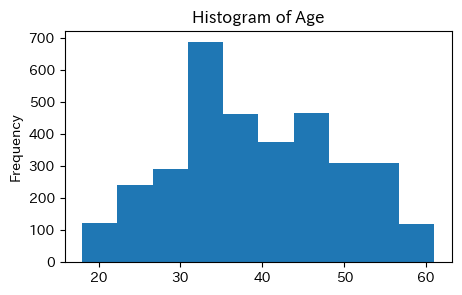

In [ ]:
visualization.HistChart(train_processed_x['Age'])

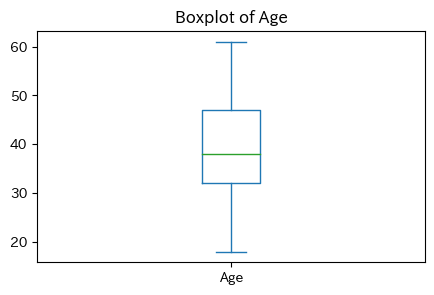

In [ ]:
visualization.BoxChart(train_processed_x['Age'])

In [ ]:
train_age.isnull().sum()

100

### 2.TypeofContact（連絡方法）

- **尺度**: 名義尺度 (Nominal Scale)
  - **説明**: `TypeofContact` は、顧客が企業とどのように接触したかを示すカテゴリカルデータです。カテゴリ間に順序はなく、単に各カテゴリの違いを識別するために使用されます。
  
- **適切な可視化方法**:
  - **棒グラフ (Bar Chart)**: 各接触方法の頻度を視覚的に比較するために有効です。バーの高さで、各接触方法の出現回数を示します。
  - **円グラフ (Pie Chart)**: 各接触方法が全体の中で占める割合を視覚化するのに適しています。特に、カテゴリ数が少ない場合に有効です。

In [ ]:
train_x['TypeofContact'].value_counts()

,count
TypeofContact,
Self Enquiry,2194
Company Invited,1289


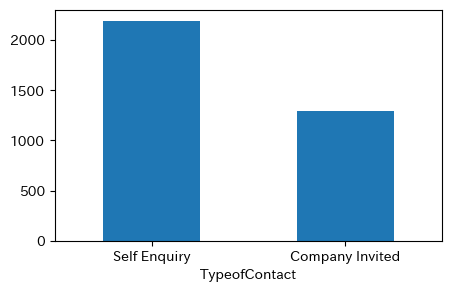

In [ ]:
BarChart(train_x['TypeofContact'])

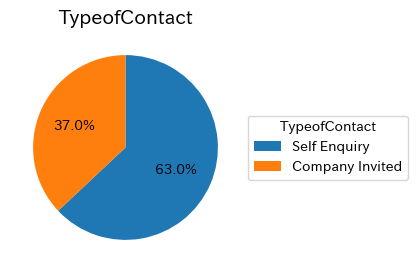

In [ ]:
PieChart(train_x['TypeofContact'])

### 3.CityTier（都市層）

- **尺度**: 順序尺度 (Ordinal Scale)
  - **説明**: `CityTier` は、都市の階層やレベルを示すカテゴリカルデータです。このデータには自然な順序があり、例えば、Tier 1 が最も高いレベル、Tier 2 がその次、Tier 3 が最も低いレベルといったように、都市の階層を表しています。ただし、階層間の差が均等であるとは限りません。

- **適切な可視化方法**:
  - **棒グラフ (Bar Chart)**: 各都市階層の頻度を視覚的に比較するために有効です。棒の高さで、各都市階層の出現回数を示します。
  - **箱ひげ図 (Box Plot)**: もし `CityTier` が数値データに変換可能であれば、階層ごとのデータ分布を確認するために使用できますが、通常は棒グラフがより一般的です。
  - **円グラフ (Pie Chart)**: 各都市階層が全体の中で占める割合を視覚化するのに適しています。特に、都市階層が少数である場合に有効です。

In [ ]:
# CityTier 順序尺度
train['CityTier'].value_counts()

,count
CityTier,
2,1596
1,1475
3,418


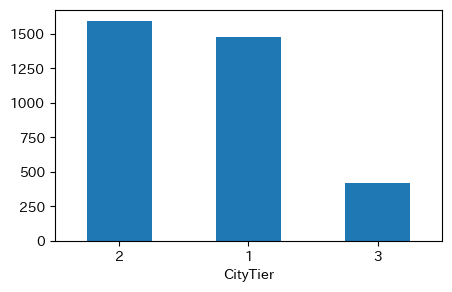

In [ ]:
BarChart(train_x['CityTier'])

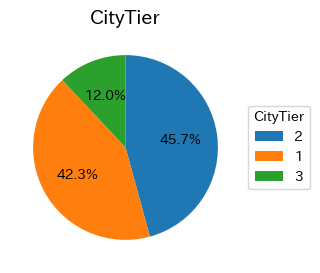

In [ ]:
PieChart(train_x['CityTier'])

### 4.DurationOfPitch（プレゼン時間）

- **尺度**: 比率尺度 (Ratio Scale)
  - **説明**: `DurationOfPitch` はプレゼンテーションの時間を示す連続した数値データです。このデータはゼロが意味を持ち、間隔が等しいため比率尺度に分類されます。ゼロは「プレゼン時間がない」ことを示し、他の値はその時間がどれだけ長いかを示します。

- **適切な可視化方法**:
  - **ヒストグラム**: プレゼンテーション時間の分布を見るために有効です。全体的な分布や偏りを視覚的に確認できます。
  - **箱ひげ図**: プレゼンテーション時間の中央値や四分位範囲、外れ値を確認するために使用できます。特に、データの中心傾向や散らばり具合、異常値を把握するのに役立ちます。

In [ ]:
train_DurationOfPitch = train_x['DurationOfPitch'].apply(preprocessing.convert_to_minutes)

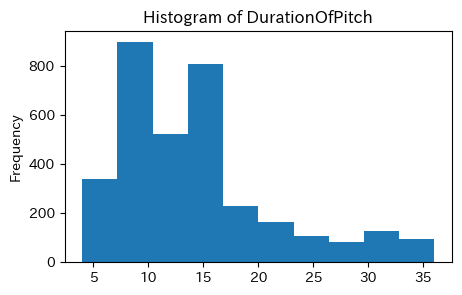

In [ ]:
HistChart(train_DurationOfPitch)

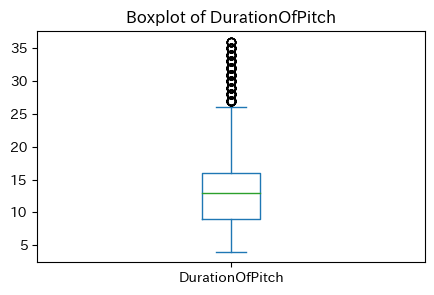

In [ ]:
BoxChart(train_DurationOfPitch)

### 5.Occupation（職業）

- **尺度**: 順序尺度 (Ordinal Scale)
  - **説明**: `Occupation` は職業を示すカテゴリカルデータで、職業間には自然な順序が存在します（例: Large Business, Small Business, Salaried）。これらのカテゴリには順序があり、例えば大企業が小企業よりも上位に位置づけられるなど、一定の階層関係がありますが、その間隔は必ずしも等しくありません。

- **適切な可視化方法**:
  - **棒グラフ (Bar Chart)**: 各職業カテゴリの頻度を視覚的に比較するために有効です。各バーの高さで、職業ごとの出現回数を示します。
  - **箱ひげ図 (Box Plot)**: もし他の数値データと組み合わせて職業カテゴリごとのデータ分布を見たい場合に使用できます。ただし、通常は棒グラフで職業ごとの頻度を比較するのが一般的です。

In [ ]:
# Occupation 順序尺度
train['Occupation'].value_counts()

,count
Occupation,
Small Business,1727
Salaried,1401
Large Business,361


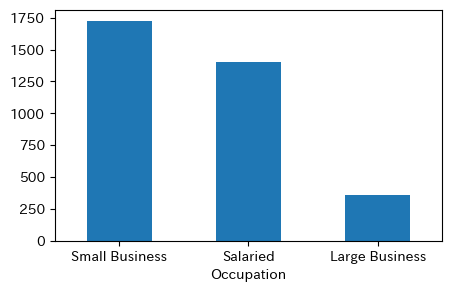

In [ ]:
BarChart(train['Occupation'])

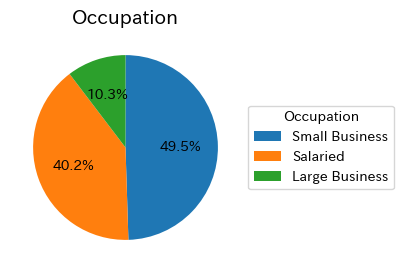

In [ ]:
PieChart(train['Occupation'])

### 6.Gender（性別）

- **尺度**: 名義尺度 (Nominal Scale)
  - **説明**: `Gender` は性別を示すカテゴリカルデータで、性別間には順序や数値的な関係がありません。これは、データが単にラベル（例: Male, Female）として使用され、それらの間に優劣や順序が存在しないため、名義尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ (Bar Chart)**: 各性別カテゴリの頻度を視覚的に比較するために有効です。各バーの高さで、性別ごとの出現回数を示します。
  - **円グラフ (Pie Chart)**: 各性別カテゴリが全体の中で占める割合を視覚化するために適しています。特に、性別の割合を比較する場合に有効です。

In [ ]:
# Gender categorical
def Gender_dealing(gender):
    # 文字列を半角に変換し、大文字に統一
    gender = unicodedata.normalize('NFKC', gender).upper().strip()
    # 不要な空白を削除
    gender = ''.join(gender.split())
    return gender

In [ ]:
train_Gender = train_x['Gender'].apply(Gender_dealing)

In [ ]:
train_Gender.value_counts()

,count
Gender,
MALE,2064
FEMALE,1425


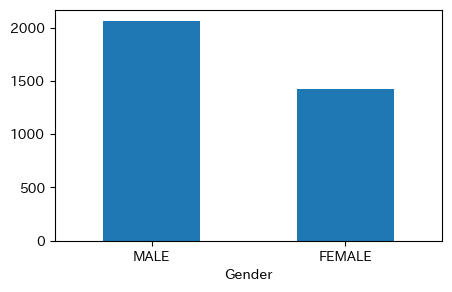

In [ ]:
BarChart(train_Gender)

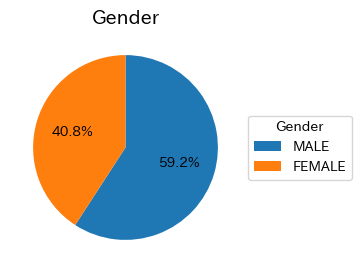

In [ ]:
PieChart(train_Gender)

### 7.NumberOfPersonVisiting（同行者数）

- **尺度**: 比率尺度 (Ratio Scale)
  - **説明**: `NumberOfPersonVisiting` はゼロが意味を持つ離散的な数値データであり、間隔も等しいため比率尺度です。同行者の人数が増えるにつれてその値も増加します。

- **適切な可視化方法**:
  - **棒グラフ**: 各人数の頻度を視覚的に比較するために有効です。特に、少数の離散値の場合に適しています。
  - **円グラフ**: 各人数が全体の中で占める割合を示すのに適しています。

In [ ]:
# NumberOfPersonVisiting numeric
train_x['NumberOfPersonVisiting'].value_counts()

,count
NumberOfPersonVisiting,
2.0,1608
3.0,1377
1.0,336
4.0,168


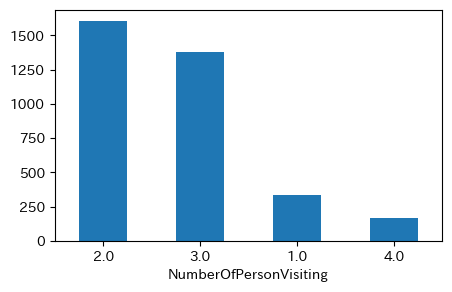

In [ ]:
BarChart(train_x['NumberOfPersonVisiting'])

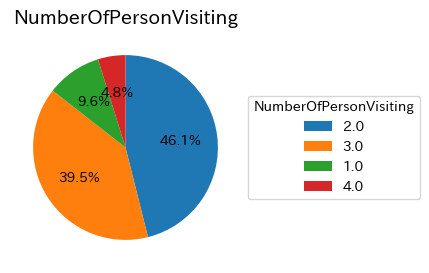

In [ ]:
PieChart(train_x['NumberOfPersonVisiting'])

### 8.NumberOfFollowups（フォローアップの回数）

- **尺度**: 比率尺度 (Ratio Scale)
  - **説明**: `NumberOfFollowups` はゼロが意味を持つ連続した数値データであり、フォローアップの回数を表します。ゼロは「フォローアップが一度も行われなかった」ことを意味し、回数が増えるごとにその値も増加します。

- **適切な可視化方法**:
  - **ヒストグラム**: フォローアップ回数の分布を見るために有効です。全体的な分布や回数の偏りを視覚的に確認できます。
  - **箱ひげ図**: フォローアップ回数の中央値や四分位範囲、外れ値を確認するために使用できます。特に、データの中心傾向や散らばり具合、異常値を把握するのに役立ちます。

In [ ]:
# NumberOfFollowups numeric
def NumberOfFollowups_dealing(input_int):
    if input_int >= 100: #常識的にx00回は記述ミスと判断
        return input_int /100
    else:
        return input_int

In [ ]:
train_NumberOfFollowups = train_x['NumberOfFollowups'].apply(NumberOfFollowups_dealing)

In [ ]:
train_NumberOfFollowups.value_counts()

,count
NumberOfFollowups,
4.0,1411
3.0,1296
5.0,524
2.0,108
1.0,78
6.0,39


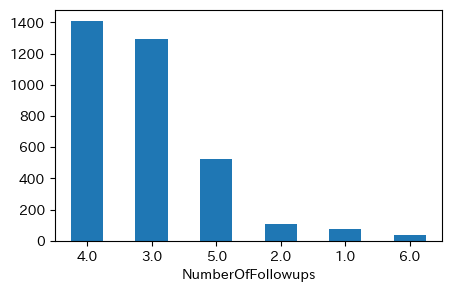

In [ ]:
BarChart(train_NumberOfFollowups)

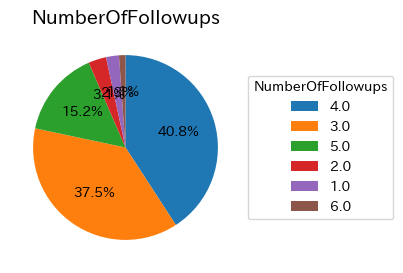

In [ ]:
PieChart(train_NumberOfFollowups)

### 9.ProductPitched（売り込み商品の種類）

- **尺度**: 名義尺度 (Nominal Scale)
  - **説明**: `ProductPitched` は、営業担当者が売り込んだ商品の種類を示すカテゴリデータであり、順序がないため名義尺度に分類されます。各商品カテゴリー間には順序や数値的な関係がありません。

- **適切な可視化方法**:
  - **棒グラフ**: 各商品の種類の頻度を視覚化するために有効です。各商品がどれだけ頻繁に売り込まれたかを比較できます。
  - **円グラフ**: 各商品の種類が全体の中で占める割合を示すために適しています。各商品カテゴリーの比率を視覚的に確認できます。

In [ ]:
def standardize_str(input_str):
    # 文字列を半角に変換し、小文字に統一
    input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
    # 不要な空白や特殊記号を削除
    input_str = ''.join(input_str.split())
    input_str = input_str.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
    # その他特殊文字を通常の英字に置換
    input_str = input_str.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
    input_str = input_str.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
    input_str = input_str.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
    input_str = input_str.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
    input_str = input_str.replace('aasic', 'basic')
    return input_str

In [ ]:
train_ProductPitched = train['ProductPitched'].apply(standardize_str)

In [ ]:
train_ProductPitched.value_counts()

,count
ProductPitched,
basic,1157
deluxe,1045
standard,841
superdeluxe,320
king,126


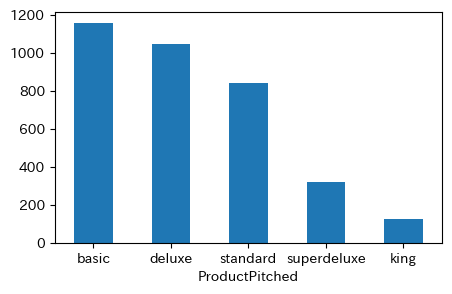

In [ ]:
BarChart(train_ProductPitched)

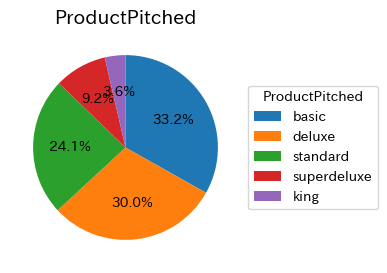

In [ ]:
PieChart(train_ProductPitched)

### 10.PreferredPropertyStar（ホテル施設の優先評価）

- **尺度**: 順序尺度 (Ordinal Scale)
  - **説明**: `PreferredPropertyStar` は、顧客が希望するホテル施設のランクを示すデータです。ランクには自然な順序があり、例えば「3つ星」より「5つ星」の方が高いランクですが、その間隔が等しいとは限らないため、順序尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ**: 各ホテルランクの頻度を視覚化するために有効です。顧客が希望するランクの分布を比較できます。
  - **円グラフ**: 各ホテルランクが全体の中で占める割合を視覚的に確認するために適しています。

In [ ]:
# PreferredPropertyStar 順序尺度
train_x['PreferredPropertyStar'].value_counts()

,count
PreferredPropertyStar,
3.0,2147
4.0,1145
5.0,197


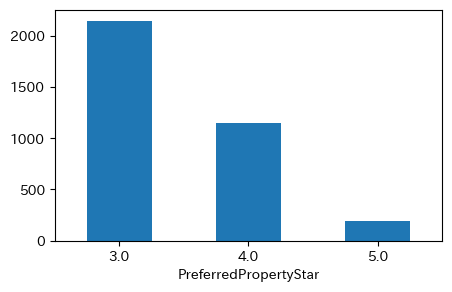

In [ ]:
BarChart(train_x['PreferredPropertyStar'])

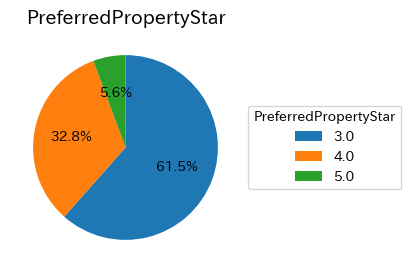

In [ ]:
PieChart(train_x['PreferredPropertyStar'])

### 11.NumberOfTrips（年間旅行回数）

- **尺度**: 比率尺度 (Ratio Scale)
  - **説明**: `NumberOfTrips` は、顧客の年間旅行回数を示す数値データであり、ゼロが意味を持つため比率尺度に分類されます。旅行回数は通常少数の離散値で、せいぜい年8回までであるため、各回数ごとの頻度を把握することが重要です。

- **適切な可視化方法**:
  - **棒グラフ**: 旅行回数が少数の離散値である場合、各旅行回数の頻度を視覚化するために非常に有効です。各棒の高さが、それぞれの旅行回数がデータセットに何回出現しているかを示します。
  - **円グラフ**: 各旅行回数が全体の中で占める割合を示すために適しています。全体に対してどの回数が多いかを視覚的に確認できます。

 まとめ  
`NumberOfTrips` のような少数の離散値データでは、**棒グラフ** が最も適切です。旅行回数の分布や頻度を視覚的に確認するのに適しています。また、全体の割合を示したい場合は、**円グラフ** も有効です。

In [ ]:
# NumberOfTrips numeric
def NumberOfTrips_dealing(str):
    if pd.isnull(str):
        return None
    if '半年に' in str:
        return 2 * int(str.replace('半年に', '').replace('回', ''))
    elif '年に' in str:
        return int(str.replace('年に', '').replace('回', ''))
    elif '四半期に' in str:
        return 4 * int(str.replace('四半期に', '').replace('回', ''))
    else :
        return int(str)

In [ ]:
train_NumberOfTrips = train_x['NumberOfTrips'].apply(NumberOfTrips_dealing)

In [ ]:
train_NumberOfTrips.value_counts()

,count
NumberOfTrips,
2.0,1164
3.0,820
5.0,515
1.0,409
7.0,256
4.0,163
6.0,130
8.0,10


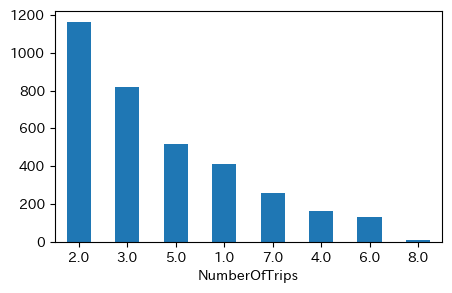

In [ ]:
BarChart(train_NumberOfTrips)

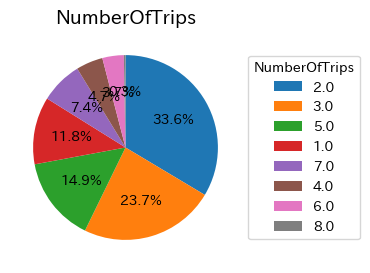

In [ ]:
PieChart(train_NumberOfTrips)

### 12.Passport（パスポートの所持）

- **尺度**: 名義尺度 (Nominal Scale)
  - **説明**: `Passport` は、顧客がパスポートを所持しているかどうかを示すカテゴリデータです。これは「所持している」か「所持していない」の2つのカテゴリに分類され、順序や数値的な関係がないため名義尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ**: パスポートを所持している顧客と所持していない顧客の頻度を視覚化するために有効です。各バーの高さで、所持と不所持の顧客数を比較できます。
  - **円グラフ**: パスポート所持者と非所持者が全体の中で占める割合を視覚化するために適しています。それぞれの割合を一目で確認できます。

In [ ]:
train_x['Passport'].value_counts()

,count
Passport,
0,3131
1,358


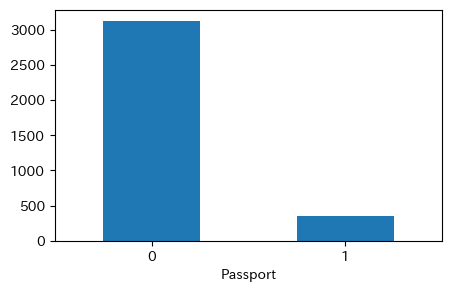

In [ ]:
BarChart(train_x['Passport'])

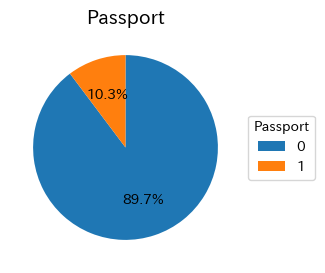

In [ ]:
PieChart(train_x['Passport'])

### 13.PitchSatisfactionScore（売り込みの満足度スコア）

- **尺度**: 順序尺度 (Ordinal Scale)
  - **説明**: `PitchSatisfactionScore` は、顧客が営業担当者の売り込みに対して感じた満足度を示すスコアです。このスコアには自然な順序があり、例えば「1」は「5」よりも低い満足度を示しますが、その間隔が等しいとは限らないため、順序尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ**: 各満足度スコアの頻度を視覚化するために有効です。顧客がどのスコアを最も多く選んでいるかを比較できます。
  - **円グラフ**: 各満足度スコアが全体の中で占める割合を視覚的に確認するために適しています。各スコアの割合を直感的に把握するのに役立ちます。

- **尺度**: 順序尺度 (Ordinal Scale)
  - **説明**: `PitchSatisfactionScore` は、顧客が営業担当者の売り込みに対して感じた満足度を示すスコアです。このスコアには自然な順序があり、例えば「1」は「5」よりも低い満足度を示しますが、その間隔が等しいとは限らないため、順序尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ**: 各満足度スコアの頻度を視覚化するために有効です。顧客がどのスコアを最も多く選んでいるかを比較できます。
  - **円グラフ**: 各満足度スコアが全体の中で占める割合を視覚的に確認するために適しています。各スコアの割合を直感的に把握するのに役立ちます。

In [ ]:
# PitchSatisfactionScore 順序尺度だけど間隔尺度的要素あり
train_x['PitchSatisfactionScore'].value_counts()

,count
PitchSatisfactionScore,
2,1269
4,739
3,692
1,686
5,103


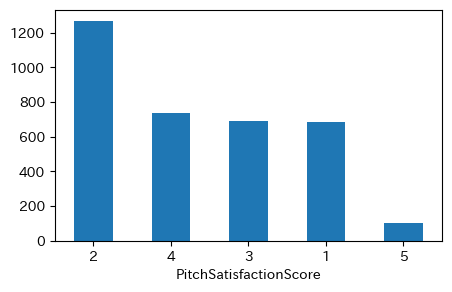

In [ ]:
BarChart(train_x['PitchSatisfactionScore'])

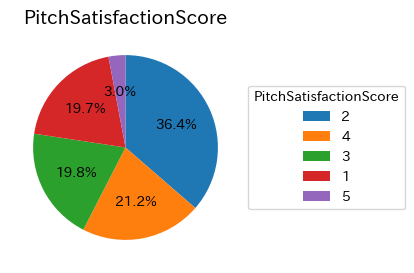

In [ ]:
PieChart(train_x['PitchSatisfactionScore'])

### 14.Designation（役職）

- **尺度**: 名義尺度 (Nominal Scale)
  - **説明**: `Designation` は、顧客の職場における役職を示すカテゴリデータです。役職は、順序や数値的な関係がなく、単なるラベルとして機能するため、名義尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ**: 各役職の頻度を視覚化するために有効です。どの役職の顧客が多いかを比較することができます。
  - **円グラフ**: 各役職が全体の中で占める割合を視覚的に確認するために適しています。全体に対して、どの役職がどのくらいの割合を占めているかを直感的に把握できます。

In [ ]:
# Designation categorical
def standardize_str(input_str):
    # 文字列を半角に変換し、小文字に統一
    input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
    # 不要な空白や特殊記号を削除
    input_str = ''.join(input_str.split())
    input_str = input_str.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
    # その他特殊文字を通常の英字に置換
    input_str = input_str.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
    input_str = input_str.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
    input_str = input_str.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
    input_str = input_str.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
    input_str = input_str.replace('aasic', 'basic')
    return input_str

In [ ]:
train_Designation = train_x['Designation'].apply(standardize_str)

In [ ]:
train_Designation.value_counts()

,count
Designation,
executive,1150
manager,1055
seniormanager,854
avp,311
vp,119


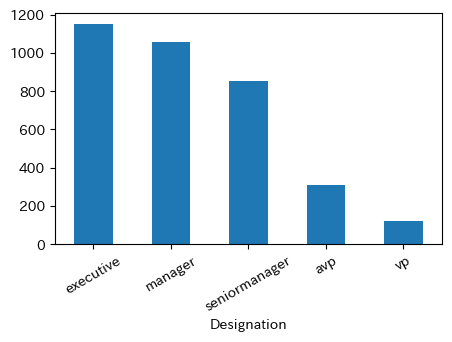

In [ ]:
BarChart(train_Designation, rot=30)

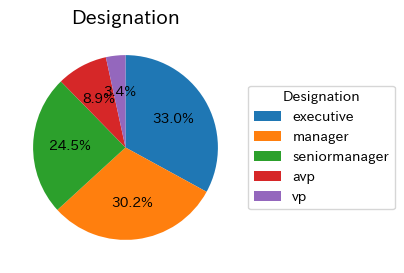

In [ ]:
PieChart(train_Designation)

### 15.MonthlyIncome（月収）


- **尺度**: 比率尺度 (Ratio Scale)
  - **説明**: `MonthlyIncome` は、顧客の月収を示す連続した数値データであり、ゼロが意味を持つため比率尺度に分類されます。月収はゼロ以上の値を取り、金額の大小による比較が可能です。また、金額間の間隔も等しいです。

- **適切な可視化方法**:
  - **ヒストグラム**: 月収の分布を見るために有効です。全体的な月収の分布や偏りを視覚的に確認できます。
  - **箱ひげ図**: 月収の中央値や四分位範囲、外れ値を確認するために使用できます。データの中心傾向や散らばり具合、異常値を把握するのに役立ちます。

In [ ]:
# MonthlyIncome numeric
def MonthlyIncome_dealing(input_str):
    if pd.isnull(input_str):
        return None
    if '月収' in input_str:
        return 10000 * float(input_str.replace('月収', '').replace('万円', ''))
    elif '万円' in input_str:
        return 10000 * float(input_str.replace('万円', ''))
    else:
        return float(input_str)

In [ ]:
train_MothlyIncom = train_x['MonthlyIncome'].apply(MonthlyIncome_dealing)

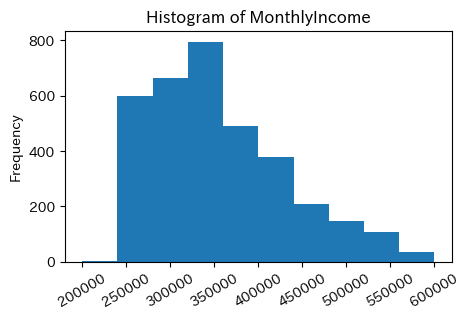

In [ ]:
HistChart(train_MothlyIncom, rot=30)

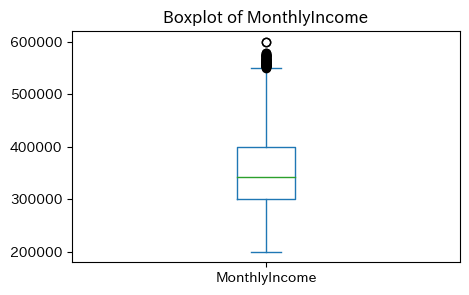

In [ ]:
BoxChart(train_MothlyIncom)

### 16.customer_info（顧客情報）

`customer_info` というフィールドは、顧客に関する複数の情報が含まれており、その内容に基づいて以下の3つのカテゴリに分類することができます。

1. `married`（婚姻状況）
- **説明**: 顧客が結婚しているかどうか、または離婚しているかなどの婚姻状況に関する情報です。
- **例**: "未婚", "既婚", "離婚済み", "独身" など。

2. `car_possession`（車の所有状況）
- **説明**: 顧客が車を所有しているかどうかに関する情報です。
- **例**: "車あり", "車なし", "自動車所有", "自動車未所有" など。

3. `offspring`（子供の有無や人数）
- **説明**: 顧客に子供がいるかどうか、または子供の人数に関する情報です。また、子供の数が不明であるかどうかも含まれます。
- **例**: "子供なし", "子供1人", "子供2人", "子供の数不明" など。

In [ ]:
# customer_info
def customer_info_dealing(input_str):
    # 文字列を半角に変換し、小文字に統一
    input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
    # 不要な空白や特殊記号を削除
    input_str = input_str.replace('/', ' ').replace('／', ' ').replace('、', ' ').replace('　', ' ')
    input_str = input_str.replace('\u3000', ' ').replace('\t', ' ').replace('\n', ' ')
    input_str = re.sub(r'(?<=\S)\s+(?=\S)', ',', input_str, count=2)
    return input_str

In [ ]:
train_customer_info = train_x['customer_info'].apply(customer_info_dealing)

In [ ]:
train_customer_info.head()

,customer_info
0,"未婚,車未所持,子供なし"
1,"離婚済み,車あり,子供無し"
2,"結婚済み,自動車未所有,子供なし"
3,"離婚済み,車所持,子供無し"
4,"独身,車所持,無子"


In [ ]:
train_customer_info_3 = train_customer_info.str.split(',', n=2, expand=True)

In [ ]:
train_married = train_customer_info_3[0]
train_car = train_customer_info_3[1]
train_offspring = train_customer_info_3[2]

#### 16-1.married（婚姻状況）

- **尺度**: 名義尺度 (Nominal Scale)
  - **説明**: `married` は、顧客の婚姻状況を示すデータであり、「未婚」「既婚」「離婚済み」などのカテゴリに分類されます。これらのカテゴリには順序がなく、単なるラベルとして機能するため、名義尺度に分類されます。
  
- **適切な可視化方法**:
  - **棒グラフ**: 各婚姻状況の頻度を視覚化するために有効です。どの婚姻状況の顧客が最も多いかを比較できます。
  - **円グラフ**: 各婚姻状況が全体の中で占める割合を視覚的に確認するために適しています。全体に対して各婚姻状況の割合を直感的に把握するのに役立ちます。

In [ ]:
!pip install japanize-matplotlib -q
import japanize_matplotlib

In [ ]:
train_married.value_counts()

,count
0,
結婚済み,1384
離婚済み,878
独身,646
未婚,581


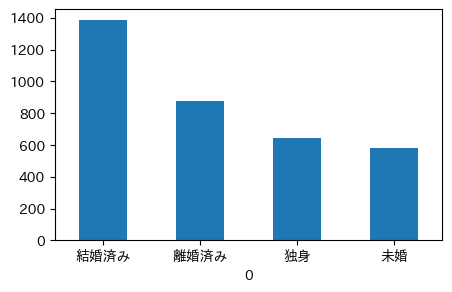

In [ ]:
BarChart(train_married)

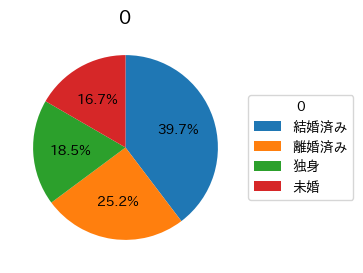

In [ ]:
PieChart(train_married)

#### 16-2.car_possession （車の所有状況）

- **尺度**: 名義尺度 (Nominal Scale)
  - **説明**: `car_possession` は、顧客が車を所有しているかどうかを示すデータです。「車あり」「車なし」などのカテゴリに分類されますが、これらのカテゴリには順序がなく、単なるラベルとして機能するため、名義尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ**: 各車の所有状況の頻度を視覚化するために有効です。どの所有状況が最も多いかを比較できます。
  - **円グラフ**: 各車の所有状況が全体の中で占める割合を視覚的に確認するために適しています。全体に対して各所有状況の割合を直感的に把握するのに役立ちます。

In [ ]:
# car_possesion categorival(dummy)
def car_possesion_dealing(input_str):
    if input_str in ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車なし', '車保有なし', 0]:
        return "車あり"
    elif input_str in ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり', 1]:
        return "車なし"

In [ ]:
train_car_possession = train_car.apply(car_possesion_dealing)

In [ ]:
train_car_possession.value_counts()

,count
1,
車あり,1785
車なし,1704


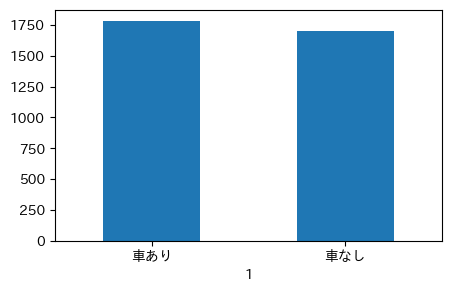

In [ ]:
BarChart(train_car_possession)

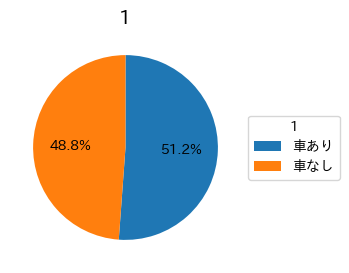

In [ ]:
PieChart(train_car_possession)

#### 16-3.offspring

In [ ]:
# offspring -1以外はnumeric
def offspring_dealing(input_str):
    if '1' in input_str:
        return 1
    elif '2' in input_str:
        return 2
    elif '3' in input_str:
        return 3
    else:
        return 0

def offspring_identified_dealing(input_str):
    if input_str in ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']:
        return 1
    else:
        return 0

##### 16-3-1.offspring_identified_dealing（子供の有無が不明かどうかの処理）

- **尺度**: 名義尺度 (Nominal Scale)

- **説明**: `offspring_identified_dealing` は、顧客の子供の有無が不明かどうかを示すデータを処理するものです。このデータは、「子供の有無が不明であるかどうか」を二つのカテゴリで表します。不明な場合は「1」、明確に分かっている場合は「0」とし、順序がないため名義尺度に分類されます。

- **適切な可視化方法**:
  - **棒グラフ**: 子供の有無が不明なケースの頻度を視覚化するために有効です。どれだけのデータが不明かを比較できます。
  - **円グラフ**: 子供の有無が不明なケースが全体の中で占める割合を視覚的に確認するために適しています。不明なケースの割合を直感的に把握するのに役立ちます。

In [ ]:
train_offsprint_offspring_identified_dealing = train_offspring.apply(offspring_identified_dealing)

In [ ]:
train_offsprint_offspring_identified_dealing.name = 'offspring_identified_dealing'

In [ ]:
train_offsprint_offspring_identified_dealing.value_counts()

,count
offspring_identified_dealing,
0,3452
1,37


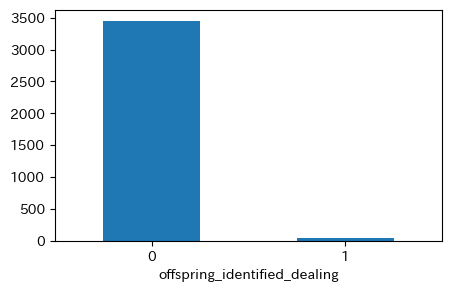

In [ ]:
BarChart(train_offsprint_offspring_identified_dealing)

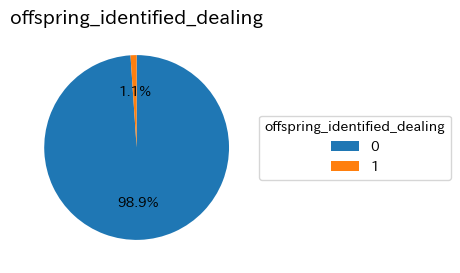

In [ ]:
PieChart(train_offsprint_offspring_identified_dealing)

##### 16-3-2.offspring_dealing（子供の有無・人数の処理）


- **尺度**: 比率尺度 (Ratio Scale)

- **説明**: offspring_dealing は、顧客の子供の人数を示すデータを処理するものです。このデータは、顧客が何人の子供を持っているかを示し、ゼロが意味を持つ数値データとして扱われます。子供がいない場合は「0」とし、子供が1人いる場合は「1」、2人いる場合は「2」などと表されます。ゼロ以上の値を取り、人数間の間隔が等しいため、比率尺度に分類されます。

適切な可視化方法:

- **棒グラフ**: 各子供の人数の頻度を視覚化するために有効です。どの人数が最も多いかを比較できます。  
- **ヒストグラム**: 子供の人数の分布を視覚化するために適しています。全体的な分布や偏りを確認できます。

In [ ]:
train_offsprint_offspring_dealing = train_offspring.apply(offspring_dealing)

In [ ]:
train_offsprint_offspring_dealing.name = 'offspring_dealing'

In [ ]:
train_offsprint_offspring_dealing.value_counts()

,count
offspring_dealing,
1,1570
0,1022
2,824
3,73


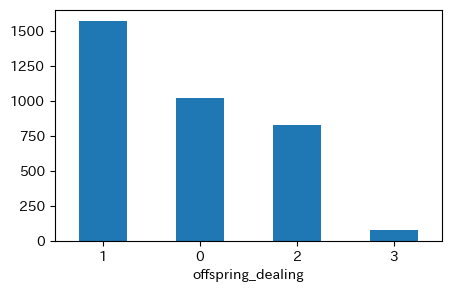

In [ ]:
BarChart(train_offsprint_offspring_dealing)

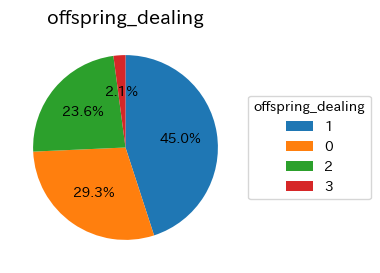

In [ ]:
PieChart(train_offsprint_offspring_dealing)

## 二変量データの分析

目的変数がカテゴリカルデータなので、説明変数の組み合わせによって以下の可視化が適切と考えられます。

 1. **説明変数が連続量の場合**
   - **箱ひげ図**: 連続データの分布や中心傾向、外れ値を視覚的に把握するのに適しています。特に、目的変数（カテゴリカルデータ）によるグループ間の比較に有効です。
   - **ビン分けと積み上げ棒グラフ**: 連続データをビンに分けることで、カテゴリデータとして扱うことができ、その後積み上げ棒グラフで成約率や分布を視覚化できます。これは、全体のトレンドやグループの違いをより直感的に理解するのに役立ちます。

 2. **説明変数が離散値の場合**
   - **積み上げ棒グラフ**: 離散データの場合、各カテゴリの頻度や割合を視覚的に比較するために非常に適しています。目的変数（カテゴリカルデータ）との関係を示すのに有効です。


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def BarChartDuble(x, y, rot=0):
    # x軸とy軸の名前を取得
    xlabel = x.name
    ylabel = y.name
    title = f'{xlabel} vs {ylabel}'

    # x軸ごとの成約・非成約のカウント
    crosstab_data = pd.crosstab(x, y)

    # 積み上げ棒グラフの表示
    ax = crosstab_data.plot(kind='bar', stacked=True, figsize=(5, 3))
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel(xlabel)

    # 各バーに成約率を表示
    for i, container in enumerate(ax.containers):
        for j, rect in enumerate(container):
            height = rect.get_height()
            if i == 1:  # 成約した場合のみ表示（i == 1は成約済みのデータ）
                # Get the index of the corresponding row in the crosstab
                index = crosstab_data.index[j]
                total = crosstab_data.loc[index].sum()
                percentage = height / total
                x = rect.get_x() + rect.get_width() / 2
                y = rect.get_y() + height + 5  # 文字が重ならないように少し上に表示
                ax.annotate(f'{percentage:.2%}', (x, y), ha='center', fontsize=10, color='black')

    plt.xticks(rotation=rot)  # x軸ラベルの回転角度を設定
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def BoxChartDuble(x, y, figsize=(5, 3)):
    # x軸とy軸の名前を取得
    xlabel = x.name
    ylabel = y.name
    title = f'{ylabel} vs {xlabel}'

    # 箱ひげ図の描画
    plt.figure(figsize=figsize)
    sns.boxplot(x=x, y=y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()


### 1.Age × ProdTaken

In [ ]:
# 年齢をいくつかのビンに分ける
train_age_bins = pd.cut(train_age, bins=[0, 20, 30, 40, 50, 60, 70, 80])

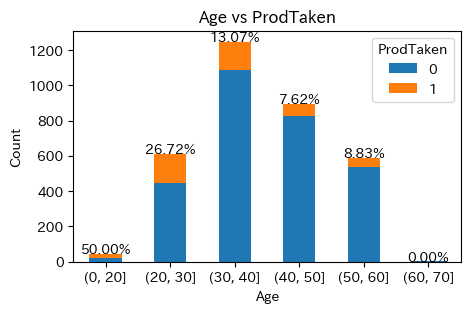

In [ ]:
BarChartDuble(train_age_bins, train_y)

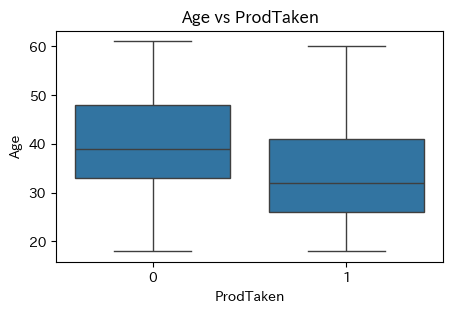

In [ ]:
BoxChartDuble(train_y, train_age)

- **成約率**:
  - 20歳以下: 50.00%
  - 20-30歳: 26.72%
  - 30-40歳: 13.07%
  - 40-50歳: 7.62%
  - 50-60歳: 8.83%
  - 60-70歳: 0.00%

- **分析**:
  - 20歳以下の成約率が最も高いが、サンプルサイズが非常に少ない。
  - 30-40歳の成約率が比較的高い。
  - 60歳以上の成約率はゼロであるため、この層へのターゲティングは非効率かもしれません。

### 2.TypeofContact × ProdTaken

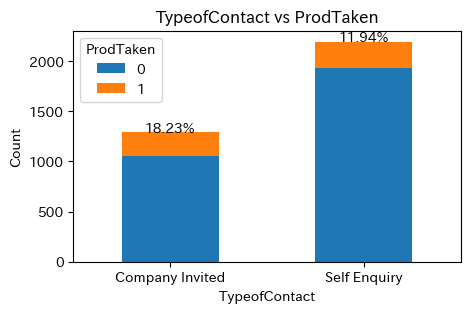

In [ ]:
BarChartDuble(train_x['TypeofContact'], train_y)

- **成約率**:
  - Company Invited: 18.23%
  - Self Enquiry: 11.94%

- **分析**:
  - Company Invited の顧客の方が Self Enquiry の顧客よりも成約率が高い。
  - 企業からの勧誘で接触した顧客の方が成約しやすいことが示唆される。



### 3.CityTier × ProdTaken

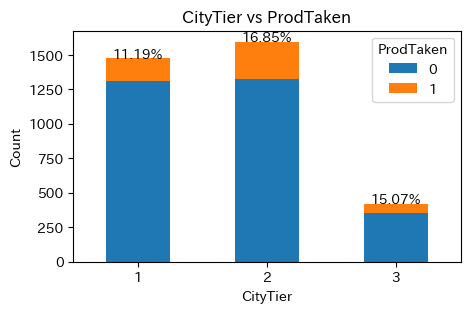

In [ ]:
BarChartDuble(train_x['CityTier'], train_y)

- **成約率**:
  - 1: 11.19%
  - 2: 16.85%
  - 3: 15.07%

- **分析**:
  - CityTier 2 において成約率が最も高い。
  - 中規模都市層が最も成約率が高く、ターゲティングに有効かもしれません。



### 4.DurationOfPitch × ProdTaken

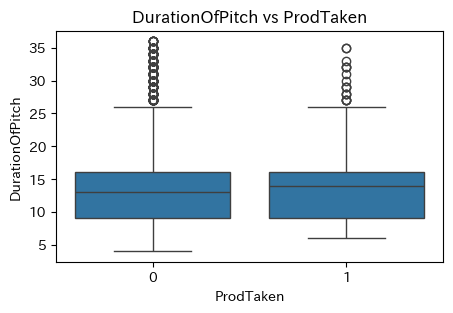

In [ ]:
BoxChartDuble(train_y, train_DurationOfPitch)

In [ ]:
# プレゼン時間をカテゴリに分ける
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40']
train_DurationOfPitch_bin = pd.cut(train_DurationOfPitch, bins=bins, labels=labels)

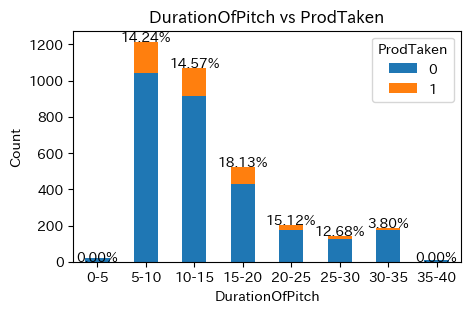

In [ ]:
BarChartDuble(train_DurationOfPitch_bin, train_y)

- **成約率**:
  - 0-5分: 0.00%
  - 5-10分: 14.24%
  - 10-15分: 14.57%
  - 15-20分: 18.13%
  - 20-25分: 15.12%
  - 25-30分: 12.68%
  - 30-35分: 3.80%
  - 35-40分: 0.00%

- **分析**:
  - プレゼン時間が15-20分の範囲で最も成約率が高い。
  - 30分以上のプレゼン時間は逆効果である可能性がある。
  - 0-5分の短時間プレゼンも成約率が低いことから、十分な説明が行われないケースは効果が薄いと考えられます。

このように、15-20分間のプレゼンテーションが最も効果的であることが示唆されています。一方で、長すぎる（30分以上）または短すぎる（5分以下）のプレゼンは、成約率を下げる可能性があるため、プレゼンテーションの長さを適切に調整することが重要です。



### 5.Occupation × ProdTaken

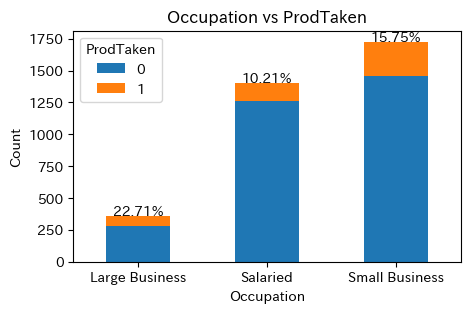

In [ ]:
# Occupation × ProdTaken の積み上げ棒グラフを作成
BarChartDuble(train_x['Occupation'], train_y)

- **成約率**:
  - Large Business: 22.71%
  - Salaried Occupation: 10.21%
  - Small Business: 15.75%

- **分析**:
  - 大規模ビジネスの顧客が最も成約率が高い。
  - 給与所得者層では成約率が低く、アプローチの改善が必要かもしれません。



### 6.Gender × ProdTaken

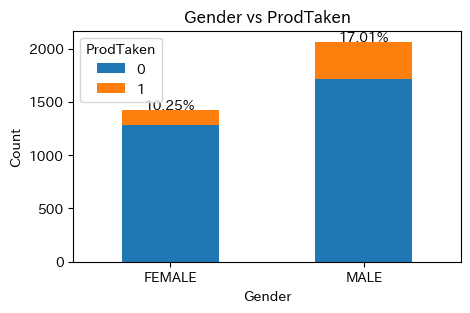

In [ ]:
BarChartDuble(train_Gender, train_y)

- **成約率**:
  - Female: 10.25%
  - Male: 17.01%

- **分析**:
  - 男性の顧客の方が成約率が高い。
  - 男性ターゲットに効果的な戦略を展開することが有効かもしれません。



### 7.NumberOfPersonVisiting × ProdTaken

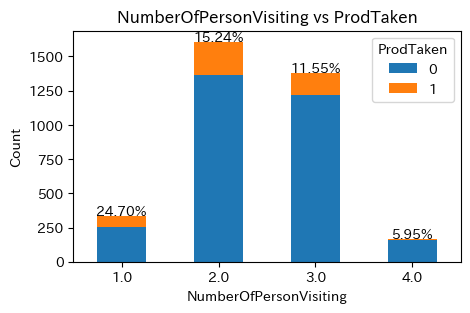

In [ ]:
BarChartDuble(train_x['NumberOfPersonVisiting'], train_y)

- **成約率**:
  - 1人: 24.70%
  - 2人: 15.24%
  - 3人: 11.55%
  - 4人: 5.95%

- **分析**:
  - 1人で訪れる顧客の成約率が最も高い。
  - 同行者の数が増えると成約率が低下する傾向がある。

### 8.NumberOfFollowups × ProdTaken

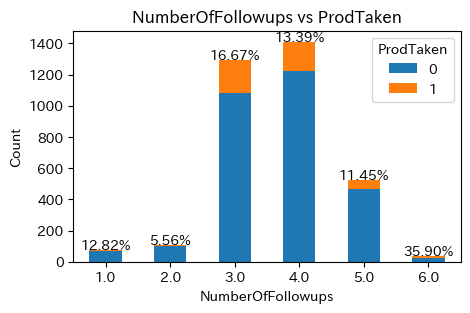

In [ ]:
BarChartDuble(train_NumberOfFollowups, train_y)

- **成約率**:
  - 1回: 12.82%
  - 2回: 5.56%
  - 3回: 16.67%
  - 4回: 13.39%
  - 5回: 11.45%
  - 6回: 35.90%

- **分析**:
  - フォローアップ回数が増えると成約率が高くなる傾向が見られるが、2回目では成約率が低下している。
  - 適切なフォローアップのタイミングを見極めることが重要です。



### 9.ProductPitched × ProdTaken

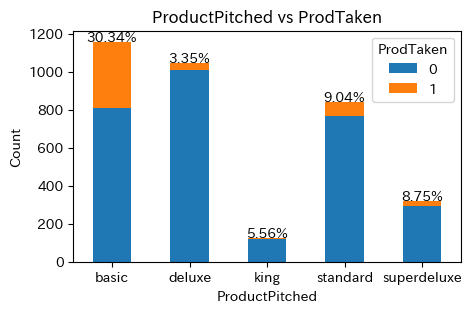

In [ ]:
BarChartDuble(train_ProductPitched, train_y)

- **成約率**:
  - Basic: 30.34%
  - Deluxe: 3.35%
  - King: 5.56%
  - Standard: 9.04%
  - Super Deluxe: 8.75%

- **分析**:
  - Basic プランの成約率が圧倒的に高い。
  - Deluxe や Super Deluxe は成約率が低いため、価格や内容の再評価が必要かもしれません。



### 10.PreferredPropertyStar × ProdTaken

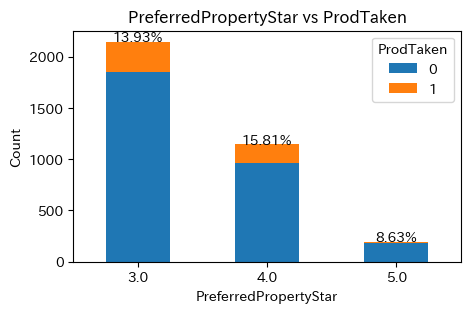

In [ ]:
BarChartDuble(train_x['PreferredPropertyStar'], train_y)

- **成約率**:
  - 3: 13.93%
  - 4: 15.81%
  - 5: 8.63%

- **分析**:
  - 4つ星ホテルを希望する顧客の成約率が最も高い。
  - 5つ星ホテルを希望する顧客の成約率は低く、高級志向の顧客には別のアプローチが必要かもしれません。

### 11.NumberOfTrips × ProdTaken

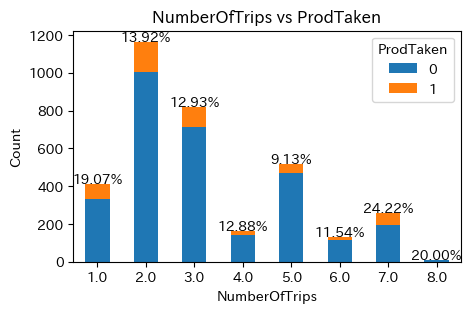

In [ ]:
BarChartDuble(train_NumberOfTrips, train_y)

- **成約率**:
  - 1回: 19.07%
  - 2回: 13.92%
  - 3回: 12.93%
  - 4回: 12.88%
  - 5回: 9.13%
  - 6回: 11.54%
  - 7回: 24.22%
  - 8回: 20.00%

- **分析**:
  - 年7回以上旅行する顧客は成約率が高い。
  - 逆に年5回旅行する顧客は成約率が低く、アプローチの見直しが必要かもしれません。



### 12.Passport × ProdTaken

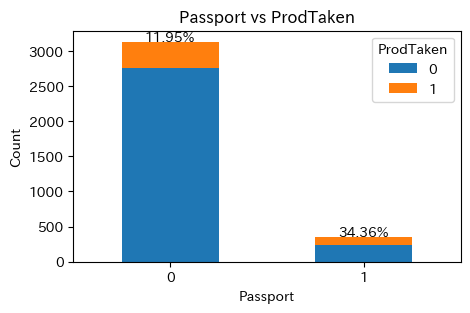

In [ ]:
BarChartDuble(train_x['Passport'], train_y)

- **成約率**:
  - 0 (未所持): 11.95%
  - 1 (所持): 34.36%

- **分析**:
  - パスポートを所持している顧客は成約率が高い。
  - 海外旅行を視野に入れた提案が効果的かもしれません。



### 13.PitchSatisfactionScore × ProdTaken

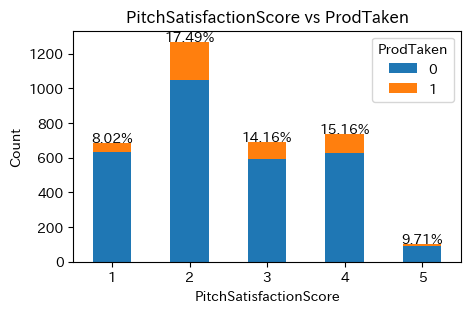

In [ ]:
BarChartDuble(train_x['PitchSatisfactionScore'], train_y)

- **成約率**:
  - 1: 8.02%
  - 2: 17.49%
  - 3: 14.16%
  - 4: 15.16%
  - 5: 9.71%

- **分析**:
  - PitchSatisfactionScore 2 の成約率が最も高い。
  - 5 の場合は成約率が低いため、期待を持たせる戦略が有効かもしれません。



### 14.Designation × ProdTaken

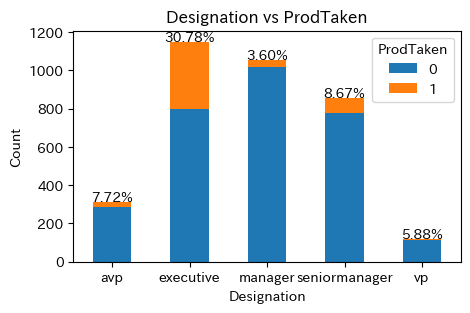

In [ ]:
BarChartDuble(train_Designation, train_y)

- **成約率**:
  - AVP: 7.72%
  - Executive: 30.78%
  - Manager: 3.60%
  - Senior Manager: 8.67%
  - VP: 5.88%

- **分析**:
  - Executive の成約率が非常に高い。
  - Manager レベルでは成約率が低いため、別のアプローチが必要かもしれません。



### 15.MonthlyIncome × ProdTaken

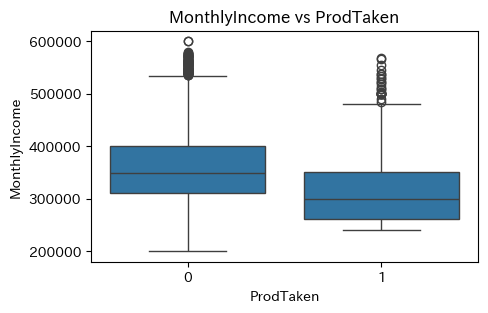

In [ ]:
# MonthlyIncomeとProdTakenの関係を箱ひげ図で可視化
BoxChartDuble(train_y, train_MothlyIncom)

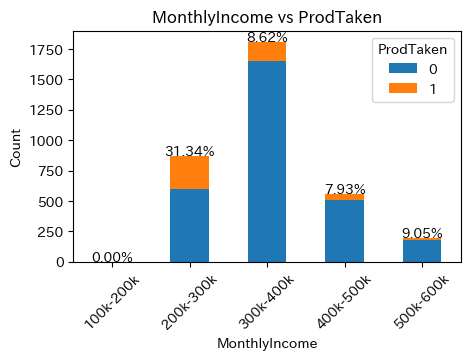

In [ ]:
import pandas as pd

# 月収をいくつかのビンに分ける
bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]
labels = ['0-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k-600k', '600k-700k', '700k-800k', '800k-900k', '900k-1M']
train_MonthlyIncome_bin = pd.cut(train_MothlyIncom, bins=bins, labels=labels)

# 積み上げ棒グラフで成約率を表示
BarChartDuble(train_MonthlyIncome_bin, train_y, rot=45)

   - **成約率**:
     - 月収が20万〜30万: 成約率は31.34%
     - 月収が30万〜40万: 成約率は8.62%
     - 月収が40万〜50万: 成約率は7.93%
     - 月収が50万〜60万: 成約率は9.05%
   - **傾向**: 月収が低い人ほど成約率が高い。特に20万〜30万の月収のグループでは成約率が高いことがわかります。

### 16.married × ProdTaken

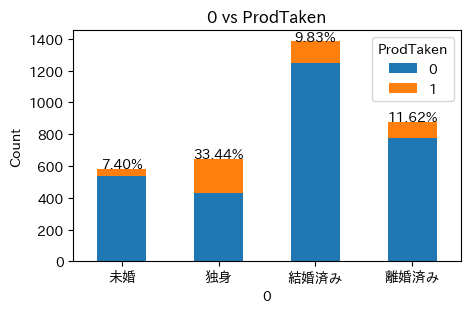

In [ ]:
BarChartDuble(train_married, train_y)

   - **成約率**:
     - 未婚: 成約率は7.40%
     - 独身: 成約率は33.44%
     - 結婚済み: 成約率は9.83%
     - 離婚済み: 成約率は11.62%
   - **傾向**: 独身の人が最も成約率が高い。その他のグループでは成約率は比較的低い。

### 17.car_possession × ProdTaken

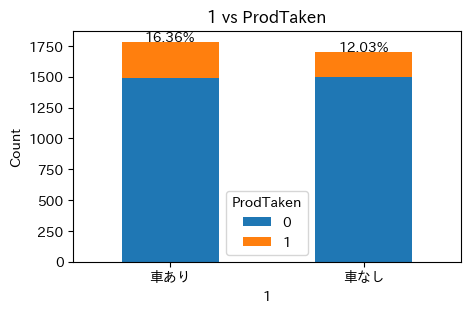

In [ ]:
BarChartDuble(train_car_possession, train_y)

   - **成約率**:
     - 車あり: 成約率は16.36%
     - 車なし: 成約率は12.03%
   - **傾向**: 車を持っている人の方が成約率が高い。



### 18.offspring_identified × ProdTaken（子供の有無が不明かどうかの処理）

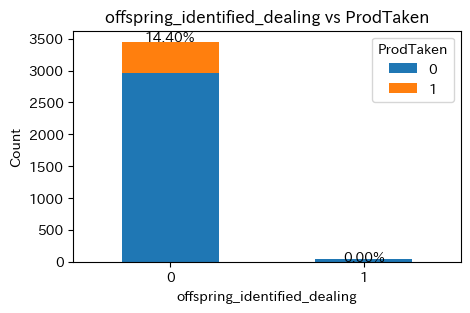

In [ ]:
BarChartDuble(train_offsprint_offspring_identified_dealing, train_y)

- **子供の人数が不明ではない**: 成約率は14.40%。
- **子供の人数が不明**: 成約率は0.00%。



### 19.offspring × ProdTaken（子供の有無・人数の処理）

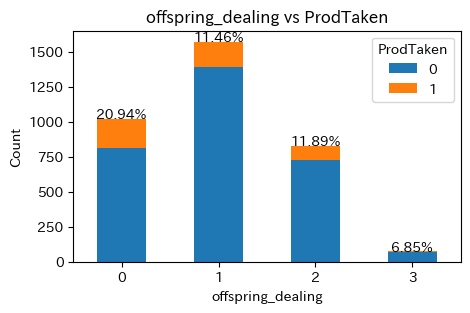

In [ ]:
BarChartDuble(train_offsprint_offspring_dealing, train_y)

- **子供なし**: 成約率は20.94%。
- **子供1人**: 成約率は11.46%。
- **子供2人**: 成約率は11.89%。
- **子供3人**: 成約率は6.85%。

このデータから、子供がいない家庭が最も成約率が高く、子供が増えるにつれて成約率が低下する傾向が見られます。

## 分析のまとめ

これらのデータと成約率の傾向から、いくつかの重要なインサイトが得られます。以下に、それぞれのカテゴリについての成約率とそこから言えることをまとめます。

1. Age × ProdTaken
- **傾向**: 30-40歳の顧客が最も成約しやすい年齢層であり、60歳以上の層では成約率が非常に低い。
- **言えること**: 若年層から中年層（特に30-40歳）をターゲットにしたマーケティング戦略が有効である可能性が高い。

2. TypeofContact × ProdTaken
- **傾向**: Company Invited（企業からの勧誘）による顧客の方が、Self Enquiry（自己問い合わせ）よりも成約率が高い。
- **言えること**: 企業主導の接触方法が効果的であり、勧誘キャンペーンの強化が有効かもしれません。

3. CityTier × ProdTaken
- **傾向**: CityTier 2（中規模都市層）が最も成約率が高い。
- **言えること**: 中規模都市に住む顧客をターゲットにすることで、成約率を向上させる可能性があります。

4. DurationOfPitch × ProdTaken
- **傾向**: プレゼン時間が10-15分の範囲で最も成約率が高いが、30分以上のプレゼンは逆効果。
- **言えること**: 効果的なプレゼン時間は10-15分であり、それ以上の時間は効果が薄れる可能性があるため、プレゼンの最適化が必要です。

5. Occupation × ProdTaken
- **傾向**: Large Business（大規模ビジネス）の顧客が最も成約しやすい。
- **言えること**: 大企業で働く顧客層に対するアプローチが効果的であり、ターゲット層を明確にすることが重要です。

6. Gender × ProdTaken
- **傾向**: 男性の成約率が女性よりも高い。
- **言えること**: 男性顧客をターゲットにした戦略が効果的であり、性別に応じたマーケティング戦略が必要です。

7. NumberOfPersonVisiting × ProdTaken
- **傾向**: 1人で訪れる顧客が最も成約しやすい。
- **言えること**: 個人旅行者向けのプロモーションが効果的であり、同行者が多い顧客には別のアプローチが必要です。

8. NumberOfFollowups × ProdTaken
- **傾向**: フォローアップ回数が多いほど成約率が高くなるが、2回目のフォローアップでは成約率が低下。
- **言えること**: フォローアップの最適な回数を見極めることで、成約率を向上させる可能性があります。

9. ProductPitched × ProdTaken
- **傾向**: Basic プランの成約率が非常に高い。
- **言えること**: よりシンプルで手頃なプランが顧客に受け入れられやすい。Deluxe や Super Deluxe には別の戦略が必要です。

10. PreferredPropertyStar × ProdTaken
- **傾向**: 4つ星ホテルを希望する顧客が最も成約しやすい。
- **言えること**: 4つ星ホテルを中心にプロモーションを行うことで、成約率の向上が期待できます。

11. NumberOfTrips × ProdTaken
- **傾向**: 年7回以上旅行する顧客の成約率が高い。
- **言えること**: 旅行頻度が高い顧客をターゲットにすることで、成約率が向上する可能性があります。

12. Passport × ProdTaken
- **傾向**: パスポートを所持している顧客の成約率が高い。
- **言えること**: 海外旅行を視野に入れた顧客に対するプロモーションが効果的です。

13. PitchSatisfactionScore × ProdTaken
- **傾向**: PitchSatisfactionScore が 2 の場合が最も成約率が高い。
- **言えること**: 満足度が低すぎず、高すぎない中間層に対するアプローチが効果的である可能性があります。

14. Designation × ProdTaken
- **傾向**: Executive の成約率が非常に高い。
- **言えること**: 役職が高い顧客層に対するアプローチが非常に効果的です。

15. MonthlyIncome × ProdTaken
- **傾向**: 月収が20万〜30万の顧客が最も成約率が高い。
- **言えること**: 中程度の所得層に対するアプローチが効果的であり、特に20万〜30万の月収層に注力すべきです。

16. married × ProdTaken
- **傾向**: 独身の顧客の成約率が最も高い。
- **言えること**: 独身者をターゲットにしたプロモーションが効果的です。

17. car_possession × ProdTaken
- **傾向**: 車を持っている顧客の方が成約率が高い。
- **言えること**: 車を所有している顧客に焦点を当てた戦略が有効です。

18. Offspring × ProdTaken
- **傾向**: 子供がいない家庭が最も成約率が高い。
- **言えること**: 子供のいない世帯にターゲットを絞ったプロモーションが効果的です。

19. Offspring_identified × ProdTaken
- **傾向**: 子供の人数が不明である場合、成約率が極端に低い。
- **言えること**: 子供の情報が明確である顧客に対するアプローチが重要です。

これらの分析結果から、ターゲット顧客層を絞り、各カテゴリに応じた戦略を展開することで、成約率の向上を図ることが可能です。

## シンプルな予測

### Age

In [ ]:
train_age_filled = train_age.fillna(train_age.median())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import random
import pandas as pd

# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(train_age_filled, train_y, test_size=0.2, random_state=42)

# トレーニングデータを年齢ビンに分ける
train_age_bins = pd.cut(X_train, bins=[0, 20, 30, 40, 50, 60, 70, 80])

# 各ビンにおける成約率を計算
age_prod_taken_grouped = y_train.groupby(train_age_bins).mean()

<ipython-input-125-5573679223ed>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_prod_taken_grouped = y_train.groupby(train_age_bins).mean()


In [ ]:
# 年齢のビンに基づく成約率を計算する関数の修正
def predict_probability_by_age(ages):
    # 各年齢に対してビンを割り当て
    age_bins = pd.cut(ages, bins=[0, 20, 30, 40, 50, 60, 70, 80])

    # ビンごとの成約率を確率として割り当て
    probs = age_bins.map(age_prod_taken_grouped)

    return probs

In [ ]:
# 検証データで予測確率を計算
y_prob = predict_probability_by_age(X_valid)

# AUCの計算
auc_score = roc_auc_score(y_valid, y_prob)
print(f"AUC: {auc_score:.2f}")

AUC: 0.67


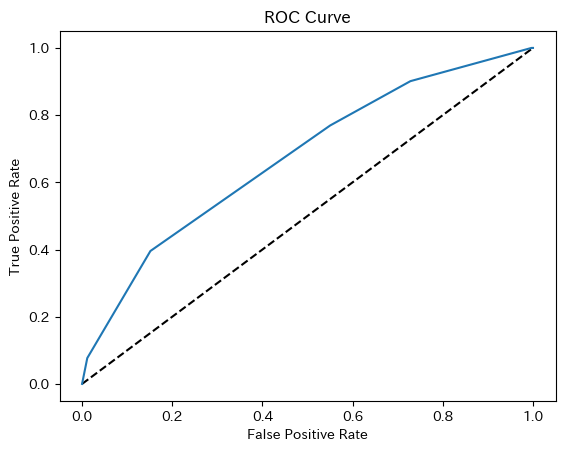

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
test_age = test_x['Age'].apply(process_age)
test_age_filled = test_age.fillna(test_age.median())

In [ ]:
# テストデータで予測を行う
y_pred = predict_probability_by_age(test_age_filled)

# 精度の評価
# テストデータには y_test は存在しないため、予測結果だけを出力します
print("Predictions:")
print(y_pred.value_counts())

Predictions:
Age
0.146592    1356
0.081944     861
0.270161     649
0.085288     568
0.500000      46
0.000000       9
Name: count, dtype: int64


In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv(data_dir + "sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [ ]:
submit[1] = y_pred
submit.head()

,0,1
0,3489,0.081944
1,3490,0.146592
2,3491,0.270161
3,3492,0.270161
4,3493,0.081944


### Age x TypeofContact

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 欠損値を中央値で補完
train_age_filled = train_age.fillna(train_age.median())
train_contact_filled = train_x['TypeofContact'].fillna(train_x['TypeofContact'].mode()[0])

# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(
    pd.DataFrame({'Age': train_age_filled, 'TypeofContact': train_contact_filled}),
    train_y,
    test_size=0.2,
    random_state=42
)

# 年齢ビンに分ける
train_age_bins = pd.cut(X_train['Age'], bins=[0, 20, 30, 40, 50, 60, 70, 80])

# 年齢ビンとTypeofContactの組み合わせごとに成約率を計算
grouped = y_train.groupby([train_age_bins, X_train['TypeofContact']]).mean()

# 年齢ビンとTypeofContactの組み合わせごとに成約・非成約のカウントを計算
crosstab_data = pd.crosstab([train_age_bins, X_train['TypeofContact']], y_train)

<ipython-input-178-10f35a83ee1c>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = y_train.groupby([train_age_bins, X_train['TypeofContact']]).mean()


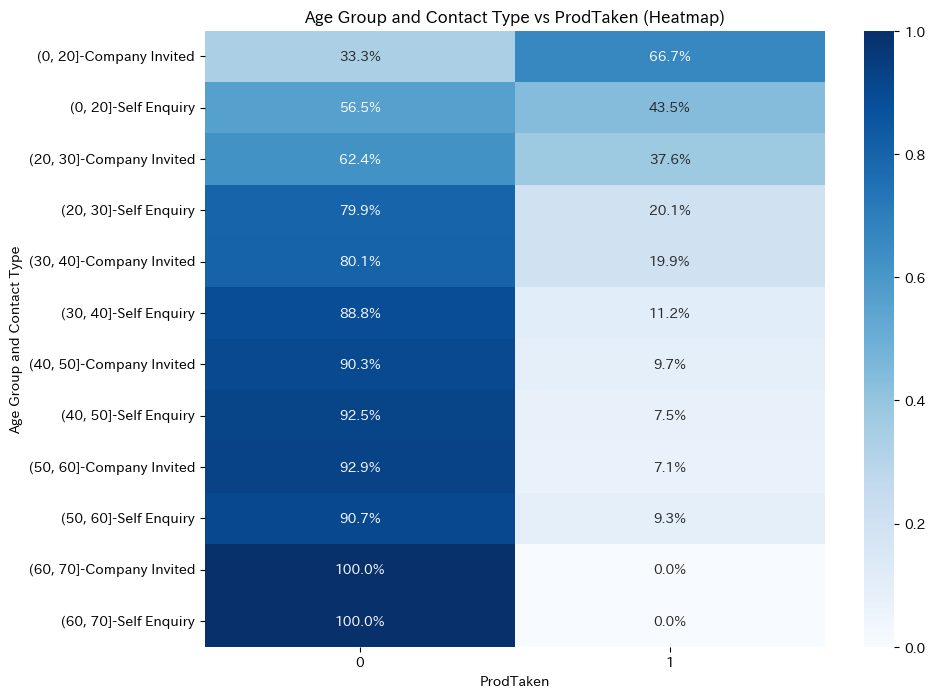

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ヒートマップ用にデータを整形
# crosstab_dataを割合に変換
crosstab_percentage = crosstab_data.div(crosstab_data.sum(axis=1), axis=0)

# ヒートマップを描画
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab_percentage, annot=True, fmt=".1%", cmap="Blues", cbar=True)

# グラフのタイトルとラベルの設定
plt.title('Age Group and Contact Type vs ProdTaken (Heatmap)')
plt.xlabel('ProdTaken')
plt.ylabel('Age Group and Contact Type')

# グラフの表示
plt.show()

In [ ]:
crosstab_percentage

ProdTaken                        0         1
Age      TypeofContact                      
(0, 20]  Company Invited  0.333333  0.666667
         Self Enquiry     0.565217  0.434783
(20, 30] Company Invited  0.624365  0.375635
         Self Enquiry     0.799331  0.200669
(30, 40] Company Invited  0.801402  0.198598
         Self Enquiry     0.888025  0.111975
(40, 50] Company Invited  0.903361  0.096639
         Self Enquiry     0.925311  0.074689
(50, 60] Company Invited  0.928571  0.071429
         Self Enquiry     0.906977  0.093023
(60, 70] Company Invited  1.000000  0.000000
         Self Enquiry     1.000000  0.000000

In [ ]:
# 予測関数の改良版（DataFrame全体を受け取る）
def predict_probability_by_X(df):
    # 各行に対して年齢ビンと連絡方法に基づいて成約率を予測
    probabilities = []
    for _, row in df.iterrows():
        age = row['Age']
        contact = row['TypeofContact']

        # 年齢に基づいてビンを特定
        age_bin = pd.cut([age], bins=[0, 20, 30, 40, 50, 60, 70, 80])[0]

        # 年齢ビンと連絡方法に基づいて成約率を予測
        prob = grouped.get((age_bin, contact), 0)  # 該当する組み合わせがない場合、確率は0とする
        probabilities.append(prob)

    return pd.Series(probabilities, index=df.index)

In [ ]:
# 検証データで予測確率を計算
y_prob = predict_probability_by_X(X_valid)

# AUCの計算
auc_score = roc_auc_score(y_valid, y_prob)
print(f"AUC: {auc_score:.2f}")

AUC: 0.65


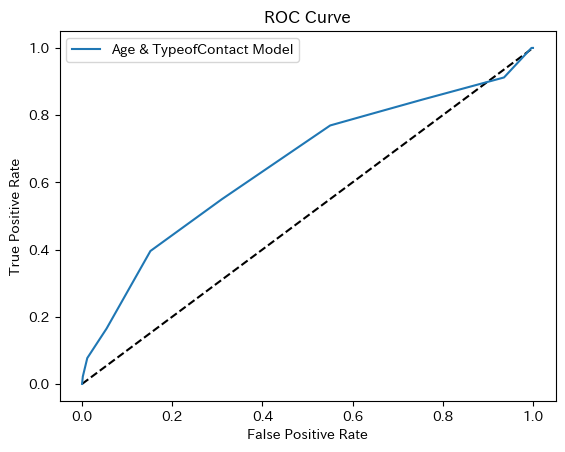

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Age & TypeofContact Model')  # ラベルを「Age & TypeofContact Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

In [ ]:
# Ageの処理
test_age = test_x['Age'].apply(process_age)
test_age_filled = test_age.fillna(test_age.median())

# TypeofContactの処理
test_contact_filled = test_x['TypeofContact'].fillna(train_contact_filled.mode()[0])  # モードで補完

In [ ]:
# テストデータで予測を行う
test_data = pd.DataFrame({'Age': test_age_filled, 'TypeofContact': test_contact_filled})
y_pred = predict_probability_by_X(test_data)

# 精度の評価（テストデータには y_test は存在しないため、予測結果だけを出力します）
print("Predictions:")
print(y_pred.value_counts())

Predictions:
0.111975    829
0.074689    589
0.198598    527
0.200669    418
0.093023    390
0.096639    272
0.375635    231
0.071429    178
0.434783     31
0.666667     15
0.000000      9
Name: count, dtype: int64


In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv(data_dir + "sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [ ]:
# 提出用データフレームに予測結果を代入
submit[1] = y_pred
submit.head()

,0,1
0,3489,0.074689
1,3490,0.111975
2,3491,0.200669
3,3492,0.375635
4,3493,0.096639


In [ ]:
# CSVファイルに書き出し
submit.to_csv('submission_age_contact.csv', index=False, header=False)

### Age x TypeofContact x Tier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 欠損値の補完
train_age_filled = train_age.fillna(train_age.median())
train_contact_filled = train_x['TypeofContact'].fillna(train_x['TypeofContact'].mode()[0])
train_citytier_filled = train_x['CityTier'].fillna(train_x['CityTier'].mode()[0])

# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(
    pd.DataFrame({
        'Age': train_age_filled,
        'TypeofContact': train_contact_filled,
        'CityTier': train_citytier_filled
    }),
    train_y,
    test_size=0.2,
    random_state=42
)

# 年齢をビンに分ける
train_age_bins = pd.cut(X_train['Age'], bins=[0, 20, 30, 40, 50, 60, 70, 80])

# 年齢ビン、TypeofContact、CityTierの組み合わせごとに成約率を計算
grouped = y_train.groupby([train_age_bins, X_train['TypeofContact'], X_train['CityTier']]).mean()


<ipython-input-333-2ee50d522c3f>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = y_train.groupby([train_age_bins, X_train['TypeofContact'], X_train['CityTier']]).mean()


In [ ]:
# 年齢ビンとTypeofContactの組み合わせごとに成約・非成約のカウントを計算
crosstab_data = pd.crosstab([train_age_bins, X_train['TypeofContact'], X_train['CityTier']], y_train)

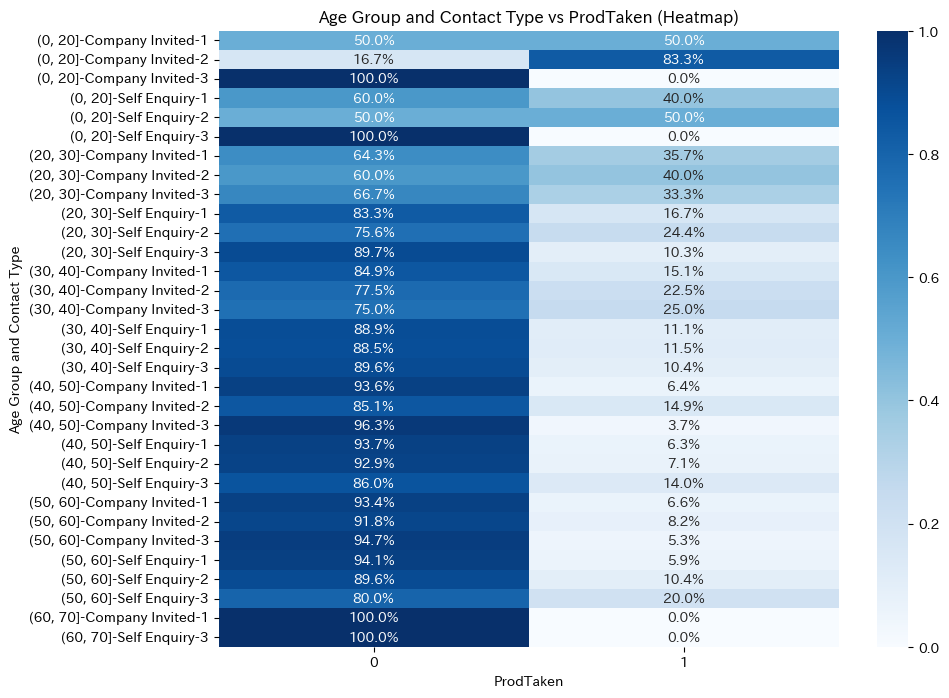

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ヒートマップ用にデータを整形
# crosstab_dataを割合に変換
crosstab_percentage = crosstab_data.div(crosstab_data.sum(axis=1), axis=0)

# ヒートマップを描画
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab_percentage, annot=True, fmt=".1%", cmap="Blues", cbar=True)

# グラフのタイトルとラベルの設定
plt.title('Age Group and Contact Type vs ProdTaken (Heatmap)')
plt.xlabel('ProdTaken')
plt.ylabel('Age Group and Contact Type')

# グラフの表示
plt.show()

In [ ]:
crosstab_percentage

ProdTaken                                 0         1
Age      TypeofContact   CityTier                    
(0, 20]  Company Invited 1         0.500000  0.500000
                         2         0.166667  0.833333
                         3         1.000000  0.000000
         Self Enquiry    1         0.600000  0.400000
                         2         0.500000  0.500000
                         3         1.000000  0.000000
(20, 30] Company Invited 1         0.642857  0.357143
                         2         0.600000  0.400000
                         3         0.666667  0.333333
         Self Enquiry    1         0.833333  0.166667
                         2         0.756410  0.243590
                         3         0.896552  0.103448
(30, 40] Company Invited 1         0.848837  0.151163
                         2         0.775000  0.225000
                         3         0.750000  0.250000
         Self Enquiry    1         0.888889  0.111111
                         2         0.885017  0.114983
                         3         0.896104  0.103896
(40, 50] Company Invited 1         0.936364  0.063636
                         2         0.851485  0.148515
                         3         0.962963  0.037037
         Self Enquiry    1         0.936937  0.063063
                         2         0.928571  0.071429
                         3         0.860000  0.140000
(50, 60] Company Invited 1         0.934211  0.065789
                         2         0.917808  0.082192
                         3         0.947368  0.052632
         Self Enquiry    1         0.941176  0.058824
                         2         0.896296  0.103704
                         3         0.800000  0.200000
(60, 70] Company Invited 1         1.000000  0.000000
         Self Enquiry    3         1.000000  0.000000

In [ ]:
crosstab_data

ProdTaken                            0   1
Age      TypeofContact   CityTier         
(0, 20]  Company Invited 1           1   1
                         2           1   5
                         3           1   0
         Self Enquiry    1           6   4
                         2           6   6
                         3           1   0
(20, 30] Company Invited 1          36  20
                         2          63  42
                         3          24  12
         Self Enquiry    1          95  19
                         2         118  38
                         3          26   3
(30, 40] Company Invited 1         146  26
                         2         155  45
                         3          42  14
         Self Enquiry    1         248  31
                         2         254  33
                         3          69   8
(40, 50] Company Invited 1         103   7
                         2          86  15
                         3          26   1
         Self Enquiry    1         208  14
                         2         195  15
                         3          43   7
(50, 60] Company Invited 1          71   5
                         2          67   6
                         3          18   1
         Self Enquiry    1         128   8
                         2         121  14
                         3          24   6
(60, 70] Company Invited 1           1   0
         Self Enquiry    3           2   0

In [ ]:
def predict_probability_by_age_contact_tier(df):
    # 各行に対して年齢ビン、連絡方法、都市層に基づいて成約率を予測
    probabilities = []
    for _, row in df.iterrows():
        age = row['Age']
        contact = row['TypeofContact']
        city_tier = row['CityTier']

        # 年齢に基づいてビンを特定
        age_bin = pd.cut([age], bins=[0, 20, 30, 40, 50, 60, 70, 80])[0]

        # 年齢ビン、TypeofContact、CityTierに基づいて成約率を予測
        prob = grouped.get((age_bin, contact, city_tier), 0)  # 該当する組み合わせがない場合、確率は0とする
        probabilities.append(prob)

    return pd.Series(probabilities, index=df.index)

In [ ]:
# 予測の実行
y_prob = predict_probability_by_age_contact_tier(X_valid)

# AUCの計算
auc_score = roc_auc_score(y_valid, y_prob)
print(f"AUC: {auc_score:.2f}")

AUC: 0.65


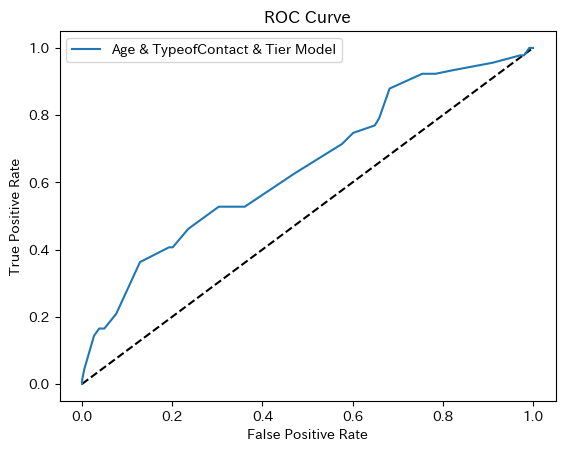

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Age & TypeofContact & Tier Model')  # ラベルを「Age & TypeofContact & Tier Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

In [ ]:
# テストデータの準備
test_age = test_x['Age'].apply(process_age)
test_age_filled = test_age.fillna(test_age.median())
test_contact_filled = test_x['TypeofContact'].fillna(test_x['TypeofContact'].mode()[0])
test_citytier_filled = test_x['CityTier'].fillna(test_x['CityTier'].mode()[0])

# テストデータで予測を行う
test_data = pd.DataFrame({
    'Age': test_age_filled,
    'TypeofContact': test_contact_filled,
    'CityTier': test_citytier_filled
})
y_pred =  predict_probability_by_age_contact_tier(test_data)

# 精度の評価（テストデータには y_test は存在しないため、予測結果だけを出力します）
print("Predictions:")
print(y_pred.value_counts())

Predictions:
0.111111    381
0.114983    364
0.063063    281
0.225000    246
0.071429    243
0.151163    214
0.243590    199
0.058824    184
0.103704    164
0.166667    161
0.400000    132
0.148515    120
0.063636    118
0.065789     86
0.103896     84
0.357143     74
0.082192     71
0.250000     67
0.140000     65
0.103448     58
0.200000     42
0.037037     34
0.333333     34
0.500000     22
0.052632     21
0.833333     11
0.000000      5
Name: count, dtype: int64


In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv(data_dir + "sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [ ]:
# 提出用データフレームに予測結果を代入
submit[1] = y_pred
submit.head()

,0,1
0,3489,0.071429
1,3490,0.114983
2,3491,0.166667
3,3492,0.400000
4,3493,0.063636


In [ ]:
# CSVファイルに書き出し
submit.to_csv('submission_age_contact_tier.csv', index=False, header=False)

### Age x TypeofContact x Tier x ...

以下、同じように付け足していく

## 応用的な分析

### クラスタ分析

In [ ]:
#分析用の前処理関数
def preprocess_data4cluster(df):
    df['Age'] = df['Age'].apply(process_age)
    # df['TypeofContact'] = df['TypeofContact'].apply(TypeofContact_to_dummy)
    # CityTier
    df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_to_minutes)
    df['Occupation'] = df['Occupation'].apply(standardize_str)
    df['Gender'] = df['Gender'].apply(Gender_dealing)
    df['NumberOfFollowups'] = df['NumberOfFollowups'].apply(NumberOfFollowups_dealing)
    df['ProductPitched'] = df['ProductPitched'].apply(standardize_str)
    df['NumberOfTrips'] = df['NumberOfTrips'].apply(NumberOfTrips_dealing)
    df['Designation'] = df['Designation'].apply(standardize_str)
    df['MonthlyIncome'] = df['MonthlyIncome'].apply(MonthlyIncome_dealing)

    customer_info_processed = df['customer_info'].apply(customer_info_dealing).str.split(',', expand=True)
    df['married'] = customer_info_processed[0]
    df['car_possession'] = customer_info_processed[1].apply(car_possesion_dealing)
    df['offspring'] = customer_info_processed[2].apply(offspring_dealing)
    df['offspring_identified'] = customer_info_processed[2].apply(offspring_identified_dealing)
    df.drop('customer_info', axis=1, inplace=True)

    # 数値データの欠損値を平均値で補完
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col].fillna(df[col].mean(), inplace=True)

    # カテゴリデータの欠損値を最頻値で補完
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # One-Hot Encoding
    df = pd.get_dummies(df, columns=[
        'TypeofContact',
        'Occupation',
        'Gender',
        'ProductPitched',
        'Designation',
        'married',
        'car_possession'
    ], drop_first=True)

    return df

In [ ]:
train_x = train.drop(['id', 'ProdTaken'], axis=1)
train_y = train['ProdTaken']
test_x = test.drop(['id'], axis=1)

In [ ]:
# データの結合
full_data = pd.concat([train_x, test_x], axis=0)

# 前処理
full_processed4cluster = preprocess_data4cluster(full_data)

NameError: name 'process_age' is not defined

In [ ]:
full_processed4cluster

,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,...,ProductPitched_standard,ProductPitched_superdeluxe,Designation_executive,Designation_manager,Designation_seniormanager,Designation_vp,married_独身,married_結婚済み,married_離婚済み,car_possession_車なし
0,50.000000,2,15.0,1.0,4.0,3.0,5.0,1,4,253905.0,...,False,False,True,False,False,False,False,False,False,False
1,56.000000,1,14.0,1.0,4.0,3.0,2.0,1,4,404475.0,...,True,False,False,False,True,False,False,False,True,True
2,39.309654,1,10.0,1.0,3.0,3.0,4.0,0,4,278145.0,...,False,False,True,False,False,False,False,True,False,False
3,37.000000,2,18.0,1.0,3.0,4.0,1.0,0,5,326805.0,...,True,False,False,False,True,False,False,False,True,True
4,48.000000,3,17.0,1.0,3.0,4.0,4.0,0,4,258435.0,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,41.000000,1,14.0,1.0,3.0,3.0,2.0,0,4,261840.0,...,False,False,True,False,False,False,False,True,False,False
3485,44.000000,1,35.0,3.0,5.0,3.0,3.0,0,3,349770.0,...,False,False,False,True,False,False,False,True,False,True
3486,24.000000,2,21.0,2.0,3.0,3.0,2.0,0,3,270000.0,...,False,False,True,False,False,False,True,False,False,False
3487,25.000000,1,9.0,2.0,3.0,3.0,2.0,0,3,272430.0,...,False,False,True,False,False,False,False,True,False,False


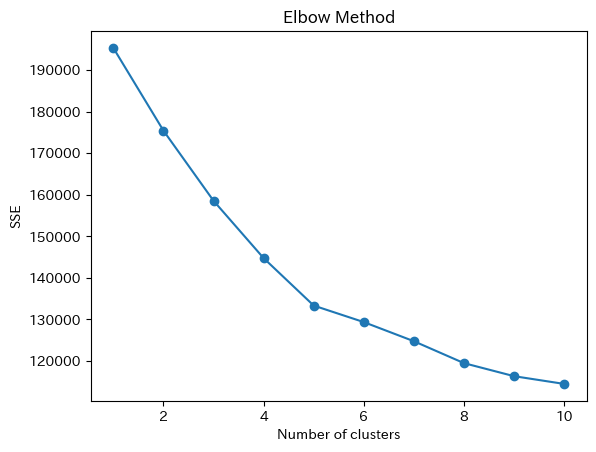

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 数値データの標準化
features_scaled = StandardScaler().fit_transform(full_processed4cluster)

# エルボー法でクラスタ数を決定
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# エルボー法のグラフをプロット
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
# 最適なクラスタ数でKMeansクラスタリングを実行
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)  # n_init を明示的に設定
kmeans.fit(features_scaled)

# クラスタリング結果を追加
full_processed4cluster['Cluster'] = kmeans.labels_

# クラスタリング結果を確認
print(full_processed4cluster['Cluster'].value_counts())

Cluster
2    2325
1    2096
3    1624
0     641
4     292
Name: count, dtype: int64


In [ ]:
full_processed4cluster.shape

(6978, 29)

In [ ]:
import pandas as pd

# クラスタごとのデータ数を確認
cluster_counts = full_processed4cluster['Cluster'].value_counts()
print("Cluster counts:\n", cluster_counts)

# 数値データのクラスタごとの平均値を計算
numeric_columns = full_processed4cluster.select_dtypes(include=['float64', 'int64']).columns
cluster_means = full_processed4cluster.groupby('Cluster')[numeric_columns].mean()
print("\nCluster means for numeric columns:\n")
display(cluster_means)

# カテゴリカルデータのクラスタごとのクロス集計を表示
categorical_columns = full_processed4cluster.select_dtypes(include=['object', 'category', 'bool']).columns
for column in categorical_columns:
    cluster_crosstab = pd.crosstab(full_processed4cluster['Cluster'], full_processed4cluster[column])
    print(f"\nCluster crosstab for {column}:\n")
    display(cluster_crosstab)

Cluster counts:
 Cluster
2    2325
1    2096
3    1624
0     641
4     292
Name: count, dtype: int64

Cluster means for numeric columns:



,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,offspring,offspring_identified
Cluster,,,,,,,,,,,,
0,48.468502,1.631825,15.503795,2.271451,3.523163,3.594384,3.507360,0.107644,2.319813,465792.748378,0.893916,0.053042
1,38.649347,1.823950,17.329334,2.463740,3.679227,3.292462,3.316515,0.075382,2.550573,338868.424940,1.080630,0.002385
2,34.254109,1.524731,13.338860,2.399140,3.714146,3.378495,3.206808,0.103226,2.605161,300937.081376,0.956129,0.002581
3,42.284673,1.810345,12.319581,2.355296,3.649015,3.647167,2.864427,0.116995,2.323276,390070.495690,0.975369,0.000000
4,47.651745,1.500000,12.556392,2.506849,3.777397,3.414384,3.674569,0.113014,2.845890,490042.825342,1.027397,0.099315



Cluster crosstab for TypeofContact_Self Enquiry:



TypeofContact_Self Enquiry,False,True
Cluster,,
0,222,419
1,752,1344
2,834,1491
3,663,961
4,45,247



Cluster crosstab for Occupation_salaried:



Occupation_salaried,False,True
Cluster,,
0,333,308
1,1137,959
2,1777,548
3,797,827
4,133,159



Cluster crosstab for Occupation_smallbusiness:



Occupation_smallbusiness,False,True
Cluster,,
0,347,294
1,1061,1035
2,900,1425
3,1035,589
4,179,113



Cluster crosstab for Gender_MALE:



Gender_MALE,False,True
Cluster,,
0,201,440
1,873,1223
2,904,1421
3,731,893
4,51,241



Cluster crosstab for ProductPitched_deluxe:



ProductPitched_deluxe,False,True
Cluster,,
0,641,0
1,30,2066
2,2314,11
3,1614,10
4,288,4



Cluster crosstab for ProductPitched_king:



ProductPitched_king,False,True
Cluster,,
0,641,0
1,2096,0
2,2321,4
3,1623,1
4,11,281



Cluster crosstab for ProductPitched_standard:



ProductPitched_standard,False,True
Cluster,,
0,641,0
1,2089,7
2,2308,17
3,38,1586
4,288,4



Cluster crosstab for ProductPitched_superdeluxe:



ProductPitched_superdeluxe,False,True
Cluster,,
0,3,638
1,2096,0
2,2323,2
3,1624,0
4,292,0



Cluster crosstab for Designation_executive:



Designation_executive,False,True
Cluster,,
0,630,11
1,2095,1
2,13,2312
3,1623,1
4,287,5



Cluster crosstab for Designation_manager:



Designation_manager,False,True
Cluster,,
0,624,17
1,19,2077
2,2322,3
3,1606,18
4,290,2



Cluster crosstab for Designation_seniormanager:



Designation_seniormanager,False,True
Cluster,,
0,627,14
1,2085,11
2,2323,2
3,35,1589
4,276,16



Cluster crosstab for Designation_vp:



Designation_vp,False,True
Cluster,,
0,632,9
1,2096,0
2,2325,0
3,1622,2
4,39,253



Cluster crosstab for married_独身:



married_独身,False,True
Cluster,,
0,477,164
1,1858,238
2,1599,726
3,1486,138
4,249,43



Cluster crosstab for married_結婚済み:



married_結婚済み,False,True
Cluster,,
0,418,223
1,1216,880
2,1506,819
3,900,724
4,92,200



Cluster crosstab for married_離婚済み:



married_離婚済み,False,True
Cluster,,
0,412,229
1,1622,474
2,1688,637
3,1319,305
4,249,43



Cluster crosstab for car_possession_車なし:



car_possession_車なし,False,True
Cluster,,
0,199,442
1,1354,742
2,1252,1073
3,699,925
4,115,177




---

**Cluster 0: 高収入・管理職・VPクラスタ**  
特性: 年齢が高く、収入が最も高い。主にVPなどの高位職。男性が多く、superdeluxe 製品を好む。車なしの割合が高く、独身率や離婚済み率も高い。

---

**Cluster 1: 高収入・シニアマネージャークラスタ**  
特性: 年齢が高く、シニアマネージャーやsmall businessに従事する人が多い。deluxe 製品を選ぶ傾向があり、車なしの割合が比較的高い。

---

**Cluster 2: 若年層・低収入・サラリーマンクラスタ**  
特性: 若年層で収入が低く、主にサラリーマン。standard 製品を選択する傾向が強い。車なし率が高いが、全体的に収入は低め。

---

**Cluster 3: 中間層・サラリーマン・スタンダードクラスタ**  
特性: 年齢と収入が中間層。standard 製品を好み、サラリーマンが多い。車なしの割合もやや高く、結婚済みの割合が比較的高い。

---

**Cluster 4: 中間層・小規模ビジネス・車なしクラスタ**  
特性: 年齢がやや高く、小規模ビジネスに従事する人が多い。king 製品を好む。車なしの割合が最も高く、vp職の割合も他のクラスタより高い。

---